In [40]:
# Cargamos nuestras librerias
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime
from tqdm.notebook import tqdm
import psycopg2
from psycopg2.extras import DictCursor
from zoneinfo import ZoneInfo

from pandas.tseries.offsets import MonthEnd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.tsa.stattools as sts
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


tz = ZoneInfo("America/Mexico_City")

sns.set_theme()

<!-- # Simulacion -->

In [2]:
class Fuga:
    def __init__(self, folio, fh_reg_incidente, id_reporte, fh_reporte, hr_reporte, clasificacion, tipo_falla, medio_recepcion, alcaldia, colonia, latitud, longitud, day, month, year, status) -> None:
        self.folio = folio
        self.fecha_registro_incidente = fh_reg_incidente
        self.id_reporte = id_reporte
        self.fecha_reporte = fh_reporte
        self.hora_reporte = hr_reporte
        self.clasificacion = clasificacion
        self.tipo_de_falla = tipo_falla
        self.medio_recepcion = medio_recepcion
        self.alcaldia_catalogo = alcaldia
        self.colonia_catalogo = colonia
        self.latitud = latitud
        self.longitud = longitud
        self.day = day
        self.month = month
        self.year = year
        self.status = status


In [6]:
def generar_datetime_aleatoria(year):
    # Generar un día y mes aleatorios
    month = random.randint(1, 12)
    day = random.randint(1, 28) if month == 2 else random.randint(1, 30) if month in [4, 6, 9, 11] else random.randint(1, 31)
    
    # Generar una hora, minuto y segundo aleatorios
    hour = random.randint(0, 23)
    minute = random.randint(0, 59)
    second = random.randint(0, 59)
    
    # Crear la fecha y hora aleatoria
    fecha_hora_aleatoria = datetime.datetime(year, month, day, hour, minute, second)
    return fecha_hora_aleatoria

In [7]:
# Probamos la función
year = 2024
test_extra = None
for _ in tqdm(range(10)):
    fecha_hora = generar_datetime_aleatoria(year)
    test_extra = fecha_hora
    print(fecha_hora)

print(fecha_hora.time())

  0%|          | 0/10 [00:00<?, ?it/s]

2024-04-05 10:07:04
2024-01-25 02:02:15
2024-08-14 22:09:19
2024-03-02 05:04:32
2024-01-26 03:19:01
2024-03-21 11:33:42
2024-10-09 05:19:28
2024-01-17 04:21:22
2024-10-13 16:46:03
2024-09-26 04:19:49
04:19:49


In [ ]:
# Extrayendo año, mes, dia, y tiempo en una tupla para probar
fecha_hora.year, fecha_hora.month, fecha_hora.day, fecha_hora.time()

(2024, 9, 26, datetime.time(4, 19, 49))

In [12]:
def run_simulation(data: pd.DataFrame, n_iterations=1000) -> pd.DataFrame:
    """
    run_simulation
    Genera registros aleatorios de las fugas de agua en CDMX
    """
    seed = np.random.randint(1, n_iterations)
    np.random.seed(seed)
    # Medios de recepción de los reportes
    medios_recepcion = ['DGSU',
    'Puesto de Mando Sacmex',
    'Redes Sociales (Instagram)',
    'Otros / Personal',
    'Ciudadano (Call Center)',
    'Redes Sociales (Facebook)',
    'Campamento o Alcaldía',
    'Secretaría de Seguridad Ciudadana (SSC)',
    'SUAC',
    'Redes Sociales (Twitter)',
    'Locatel folio',
    'C-5 (Protección Civil, Bomberos, Locatel)',
    'Medios de Comunicación',
    'Puesto de Mando',
    'Servicio de Atención Ciudadana',
    'Personal Directivo de SACMEX',
    'Jefatura de Gobierno/Base Cúspide']
    listStatus = ['REPORTADO', 'EN PROCESO', 'EN REVISIÓN', 'ATENDIENDO', 'SOLUCIONANDO', 'RESUELTO']
    results = []
    for _ in tqdm(range(n_iterations)):
        # Seleccionar filas aleatorias del DataFrame
        sample = data.sample(n=1, random_state=np.random.randint(1, n_iterations))

        # Crear un nuevo registro con valores aleatorios
        fh_reporte = generar_datetime_aleatoria(year)
        new_record = Fuga(
            folio=f"I-{np.random.randint(20230101, 20231231)}-{np.random.randint(1000, 9999)}",
            fh_reg_incidente=fh_reporte + datetime.timedelta(days=np.random.randint(1, 10)),
            id_reporte=f"R-{np.random.randint(20230101, 20231231)}-{np.random.randint(1000, 9999)}",
            fh_reporte=fh_reporte.date(),
            hr_reporte=fh_reporte.time(),
            clasificacion=np.random.choice(['Agua Tratada', 'Agua Potable']),
            tipo_falla='Fuga',
            medio_recepcion=np.random.choice(medios_recepcion),
            alcaldia=np.random.choice(data[data['alcaldia_catalogo'] != 'NA']['alcaldia_catalogo'].unique()),
            colonia=np.random.choice(data[data['colonia_catalogo'] != 'NA']['colonia_catalogo'].unique()),
            latitud=np.random.uniform(19.2, 19.5),
            longitud=np.random.uniform(-99.3, -99.0),
            day=fh_reporte.day,
            month=fh_reporte.month,
            year=fh_reporte.year,
            status=np.random.choice(listStatus)
        )
        results.append(new_record.__dict__)
    
    return pd.DataFrame(results)

# Simulanción Montecarlo

In [3]:
# Cargamos nuestro historico
data = pl.read_parquet("../DATASETS/fugas.parquet.gzip")

In [14]:
# 1eras filas
data.head()

shape: (5, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ folio     ┆ fecha_reg ┆ id_report ┆ fecha_rep ┆ … ┆ alcaldia_ ┆ colonia_c ┆ latitud   ┆ longitud │
│ ---       ┆ istro_inc ┆ e         ┆ orte      ┆   ┆ catalogo  ┆ atalogo   ┆ ---       ┆ ---      │
│ str       ┆ idente    ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64      │
│           ┆ ---       ┆ str       ┆ datetime[ ┆   ┆ str       ┆ str       ┆           ┆          │
│           ┆ datetime[ ┆           ┆ ns]       ┆   ┆           ┆           ┆           ┆          │
│           ┆ ns]       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 20210107- ┆ null      ┆ null      ┆ 2021-01-0 ┆ … ┆ TLAHUAC   ┆ LAS       ┆ 19.310192 ┆ -99.0477 │
│ 0129      ┆           ┆           ┆ 7         ┆   ┆           ┆ ARBOLEDAS ┆           ┆ 86       │
│           ┆           ┆           ┆ 00:00:00  ┆   ┆           ┆           ┆           ┆          │
│ 20210101- ┆ null      ┆ null      ┆ 2021-01-0 ┆ … ┆ IZTAPALAP ┆ EJERCITO  ┆ 19.370615 ┆ -99.0304 │
│ 0008      ┆           ┆           ┆ 1         ┆   ┆ A         ┆ DE        ┆           ┆ 13       │
│           ┆           ┆           ┆ 00:00:00  ┆   ┆           ┆ ORIENTE   ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ (U HAB) I ┆           ┆          │
│ 20210101- ┆ null      ┆ null      ┆ 2021-01-0 ┆ … ┆ ALVARO    ┆ 2DA       ┆ 19.375857 ┆ -99.2338 │
│ 0020      ┆           ┆           ┆ 1         ┆   ┆ OBREGON   ┆ JALALPA   ┆           ┆ 19       │
│           ┆           ┆           ┆ 00:00:00  ┆   ┆           ┆ TEPITO    ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ (AMPL)    ┆           ┆          │
│ 20210101- ┆ null      ┆ null      ┆ 2021-01-0 ┆ … ┆ ALVARO    ┆ CRISTO    ┆ 19.388433 ┆ -99.2018 │
│ 0048      ┆           ┆           ┆ 1         ┆   ┆ OBREGON   ┆ REY       ┆           ┆ 5        │
│           ┆           ┆           ┆ 00:00:00  ┆   ┆           ┆           ┆           ┆          │
│ 20210101- ┆ null      ┆ null      ┆ 2021-01-0 ┆ … ┆ AZCAPOTZA ┆ UN HOGAR  ┆ 19.473759 ┆ -99.1765 │
│ 0049      ┆           ┆           ┆ 1         ┆   ┆ LCO       ┆ PARA CADA ┆           ┆ 27       │
│           ┆           ┆           ┆ 00:00:00  ┆   ┆           ┆ TRABAJADO ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ R         ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [16]:
# Total filas y columnas cargadas
print(f'Total registros: {data.shape[0]}\nTotal columnas: {data.shape[1]}')

Total registros: 138640
Total columnas: 12


In [17]:
# Simulando 10000
simulated_data = run_simulation(data=data.to_pandas(), n_iterations=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
# 1eros registros de los datos simulados
simulated_data

folio fecha_registro_incidente       id_reporte fecha_reporte  \
0     I-20230857-3334      2024-08-14 04:16:45  R-20231207-1480    2024-08-10   
1     I-20230376-5224      2024-08-03 14:24:40  R-20230136-8419    2024-07-31   
2     I-20230178-4392      2024-09-28 17:05:09  R-20230324-2281    2024-09-19   
3     I-20230857-5264      2024-07-21 12:14:30  R-20230523-7151    2024-07-19   
4     I-20230165-1876      2024-03-19 21:18:53  R-20230729-3049    2024-03-16   
...               ...                      ...              ...           ...   
9995  I-20230410-6518      2024-11-23 21:57:18  R-20231208-7639    2024-11-19   
9996  I-20230854-2451      2024-07-14 16:20:20  R-20230234-5601    2024-07-10   
9997  I-20230808-7030      2024-11-04 20:44:44  R-20230464-8582    2024-11-03   
9998  I-20231063-4565      2024-12-05 23:49:39  R-20230626-3298    2024-11-27   
9999  I-20230411-7852      2024-12-18 15:59:26  R-20230699-2571    2024-12-15   

     hora_reporte clasificacion tipo_de_falla  \
0        04:16:45  Agua Potable          Fuga   
1        14:24:40  Agua Tratada          Fuga   
2        17:05:09  Agua Tratada          Fuga   
3        12:14:30  Agua Potable          Fuga   
4        21:18:53  Agua Potable          Fuga   
...           ...           ...           ...   
9995     21:57:18  Agua Tratada          Fuga   
9996     16:20:20  Agua Tratada          Fuga   
9997     20:44:44  Agua Potable          Fuga   
9998     23:49:39  Agua Tratada          Fuga   
9999     15:59:26  Agua Potable          Fuga   

                        medio_recepcion       alcaldia_catalogo  \
0            Redes Sociales (Instagram)          ALVARO OBREGON   
1                         Locatel folio                 TLAHUAC   
2             Redes Sociales (Facebook)   CUAJIMALPA DE MORELOS   
3     Jefatura de Gobierno/Base Cúspide              CUAUHTEMOC   
4            Redes Sociales (Instagram)          Álvaro Obregón   
...                                 ...                     ...   
9995            Ciudadano (Call Center)           BENITO JUAREZ   
9996       Personal Directivo de SACMEX              MILPA ALTA   
9997  Jefatura de Gobierno/Base Cúspide       GUSTAVO A. MADERO   
9998                               SUAC          Miguel Hidalgo   
9999                    Puesto de Mando  LA MAGDALENA CONTRERAS   

                    colonia_catalogo    latitud   longitud  day  month  year  \
0             El Piru 2da Ampliacion  19.445022 -99.083052   10      8  2024   
1                          La Planta  19.236461 -99.292003   31      7  2024   
2                        PROVIDENCIA  19.313443 -99.046494   19      9  2024   
3                  HIPODROMO CONDESA  19.433645 -99.154349   19      7  2024   
4     SANTA MARIA AZTAHUACAN (EJ) II  19.278770 -99.071977   16      3  2024   
...                              ...        ...        ...  ...    ...   ...   
9995              Barrio Santa Lucia  19.204625 -99.151880   19     11  2024   
9996                LA ESMERALDA III  19.336959 -99.162828   10      7  2024   
9997      PEDREGAL DE STO DOMINGO IV  19.298391 -99.181271    3     11  2024   
9998                GRANJAS MEXICO I  19.280149 -99.028970   27     11  2024   
9999            Ciudad Universitaria  19.270438 -99.192429   15     12  2024   

            status  
0     SOLUCIONANDO  
1       ATENDIENDO  
2       EN PROCESO  
3         RESUELTO  
4      EN REVISIÓN  
...            ...  
9995    ATENDIENDO  
9996      RESUELTO  
9997      RESUELTO  
9998  SOLUCIONANDO  
9999    EN PROCESO  

[10000 rows x 16 columns]

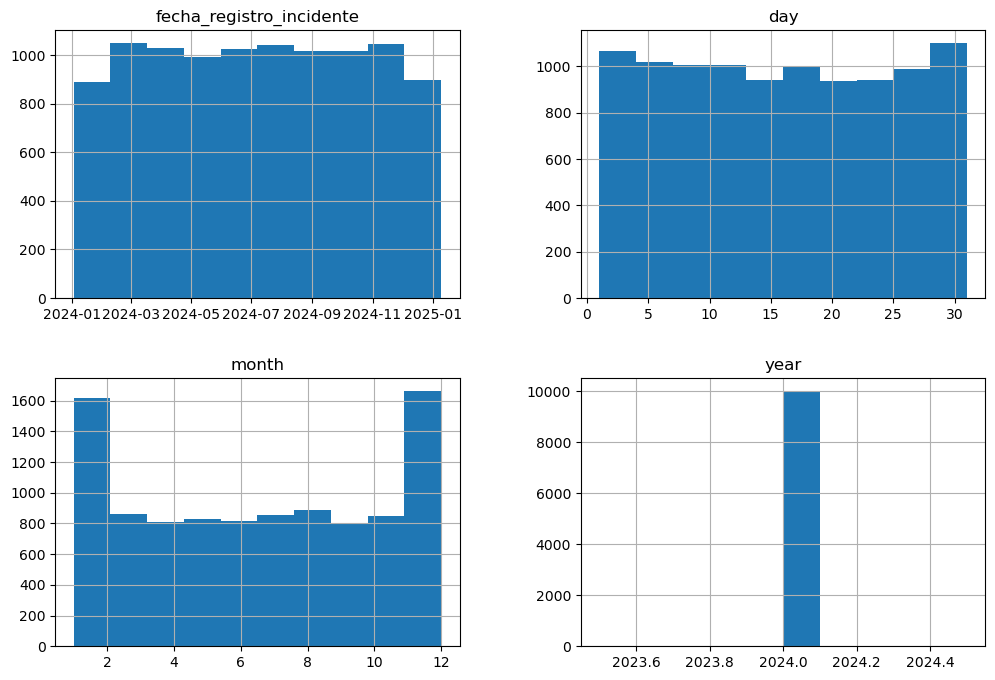

In [19]:
# Histograma
simulated_data[['fecha_registro_incidente', 'day', 'month', 'year']].hist(figsize=(12, 8))
plt.show()

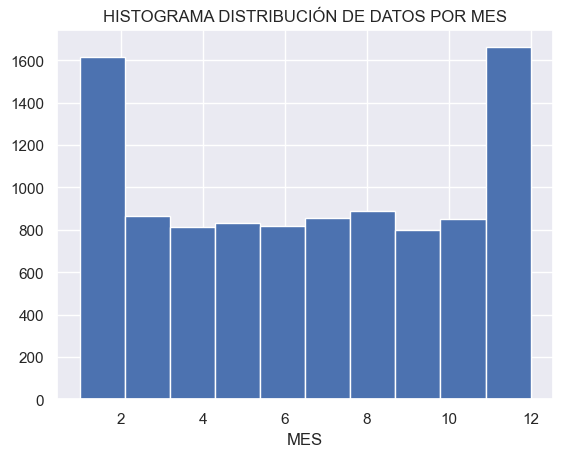

In [ ]:
# Distribución datos por mes
sns.set_theme()

g = simulated_data['month'].hist(bins=10)
g.set(
    title="Histograma distribución de datos por mes".upper(),
    xlabel="MES"
)
plt.show()

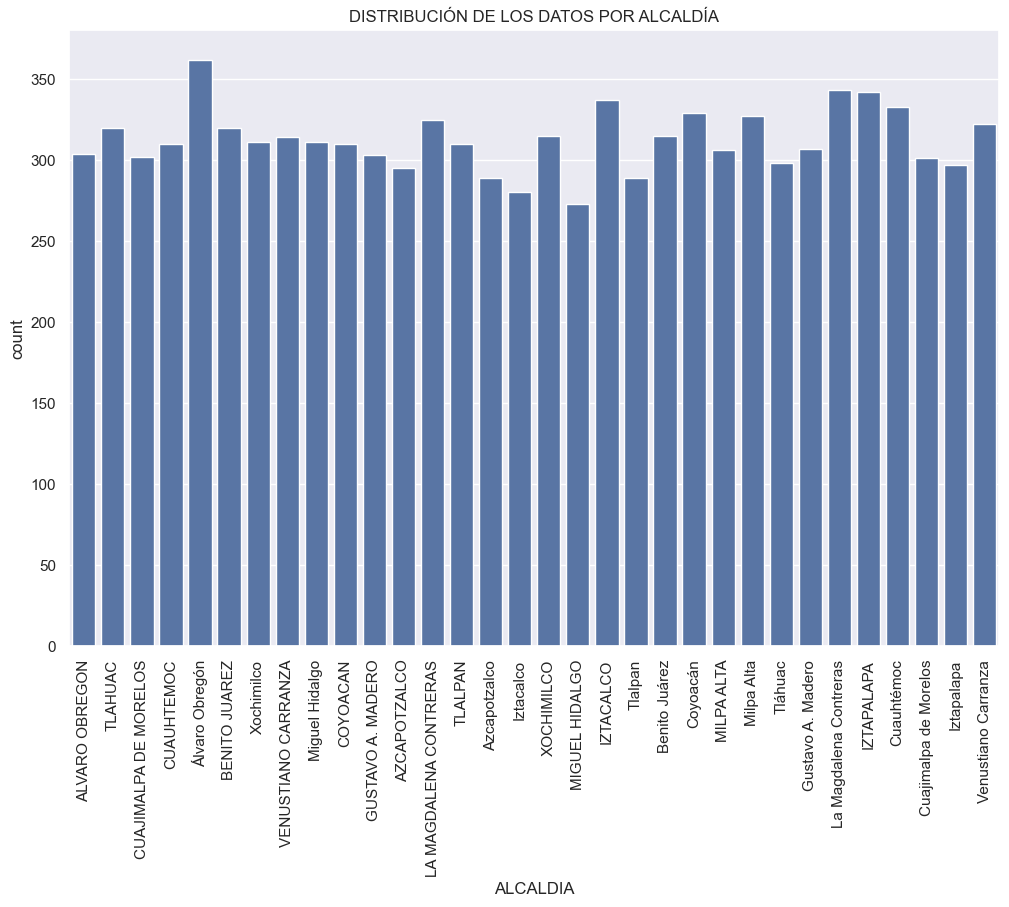

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))

g = sns.countplot(data=simulated_data, x='alcaldia_catalogo', ax=ax)
plt.xticks(rotation=90)
g.set(
    title="Distribución de los datos por Alcaldía".upper(),
    xlabel="alcaldia".upper()
)

plt.show()

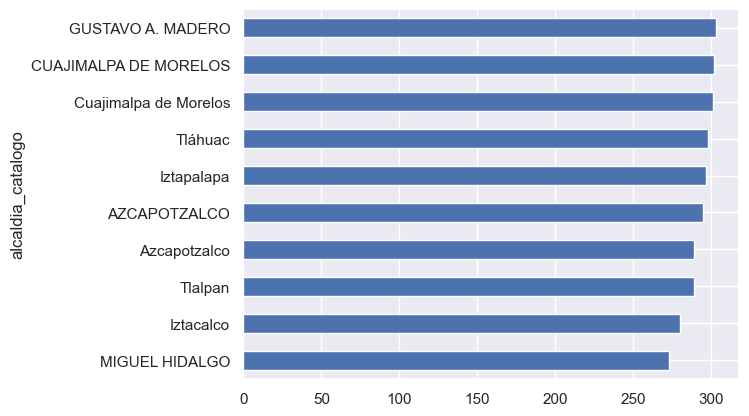

In [28]:
simulated_data['alcaldia_catalogo'].value_counts(sort=True, ascending=True).iloc[:10].plot(kind='barh')
plt.show()

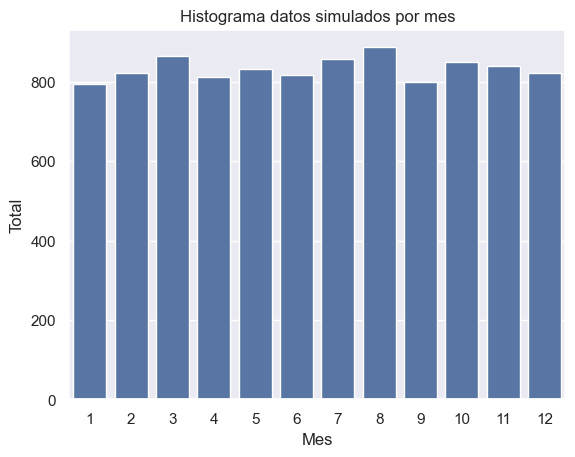

In [29]:
g = sns.countplot(data=simulated_data, x='month')
g.set(
    xlabel="Mes",
    ylabel="Total",
    title="Histograma datos simulados por mes"
)
# axes[1,0].set_title('Distribución por Mes')
# axes[1,0].set_xlabel('Mes')
# axes[1,0].set_ylabel('Cantidad de Incidentes')
plt.show()

In [30]:
# Guardamos los datos simulados
simulated_data.to_parquet('../DATASETS/datos_simulados.parquet.gzip', index=False, compression='gzip')

# Forecasting

In [4]:
# Historico creado
dfp = pl.read_parquet("../DATASETS/fugas.parquet.gzip")

In [5]:
dfp.head()

shape: (5, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ folio     ┆ fecha_reg ┆ id_report ┆ fecha_rep ┆ … ┆ alcaldia_ ┆ colonia_c ┆ latitud   ┆ longitud │
│ ---       ┆ istro_inc ┆ e         ┆ orte      ┆   ┆ catalogo  ┆ atalogo   ┆ ---       ┆ ---      │
│ str       ┆ idente    ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64      │
│           ┆ ---       ┆ str       ┆ datetime[ ┆   ┆ str       ┆ str       ┆           ┆          │
│           ┆ datetime[ ┆           ┆ ns]       ┆   ┆           ┆           ┆           ┆          │
│           ┆ ns]       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 20210107- ┆ null      ┆ null      ┆ 2021-01-0 ┆ … ┆ TLAHUAC   ┆ LAS       ┆ 19.310192 ┆ -99.0477 │
│ 0129      ┆           ┆           ┆ 7         ┆   ┆           ┆ ARBOLEDAS ┆           ┆ 86       │
│           ┆           ┆           ┆ 00:00:00  ┆   ┆           ┆           ┆           ┆          │
│ 20210101- ┆ null      ┆ null      ┆ 2021-01-0 ┆ … ┆ IZTAPALAP ┆ EJERCITO  ┆ 19.370615 ┆ -99.0304 │
│ 0008      ┆           ┆           ┆ 1         ┆   ┆ A         ┆ DE        ┆           ┆ 13       │
│           ┆           ┆           ┆ 00:00:00  ┆   ┆           ┆ ORIENTE   ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ (U HAB) I ┆           ┆          │
│ 20210101- ┆ null      ┆ null      ┆ 2021-01-0 ┆ … ┆ ALVARO    ┆ 2DA       ┆ 19.375857 ┆ -99.2338 │
│ 0020      ┆           ┆           ┆ 1         ┆   ┆ OBREGON   ┆ JALALPA   ┆           ┆ 19       │
│           ┆           ┆           ┆ 00:00:00  ┆   ┆           ┆ TEPITO    ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ (AMPL)    ┆           ┆          │
│ 20210101- ┆ null      ┆ null      ┆ 2021-01-0 ┆ … ┆ ALVARO    ┆ CRISTO    ┆ 19.388433 ┆ -99.2018 │
│ 0048      ┆           ┆           ┆ 1         ┆   ┆ OBREGON   ┆ REY       ┆           ┆ 5        │
│           ┆           ┆           ┆ 00:00:00  ┆   ┆           ┆           ┆           ┆          │
│ 20210101- ┆ null      ┆ null      ┆ 2021-01-0 ┆ … ┆ AZCAPOTZA ┆ UN HOGAR  ┆ 19.473759 ┆ -99.1765 │
│ 0049      ┆           ┆           ┆ 1         ┆   ┆ LCO       ┆ PARA CADA ┆           ┆ 27       │
│           ┆           ┆           ┆ 00:00:00  ┆   ┆           ┆ TRABAJADO ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ R         ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [6]:
df = dfp.with_columns(
    alcaldia_catalogo = pl.col("alcaldia_catalogo").str.to_uppercase(),
    colonia_catalogo = pl.col("colonia_catalogo").str.to_uppercase(),
    day=pl.col("fecha_reporte").dt.day(),
    month=pl.col("fecha_reporte").dt.month(),
    year=pl.col("fecha_reporte").dt.year(),
    status=pl.lit("RESUELTO")
)

In [7]:
# Muestra de 5
df.sample(5)

shape: (5, 16)
┌───────────────┬───────────────┬───────────────┬──────────────┬───┬─────┬───────┬──────┬──────────┐
│ folio         ┆ fecha_registr ┆ id_reporte    ┆ fecha_report ┆ … ┆ day ┆ month ┆ year ┆ status   │
│ ---           ┆ o_incidente   ┆ ---           ┆ e            ┆   ┆ --- ┆ ---   ┆ ---  ┆ ---      │
│ str           ┆ ---           ┆ str           ┆ ---          ┆   ┆ i8  ┆ i8    ┆ i32  ┆ str      │
│               ┆ datetime[ns]  ┆               ┆ datetime[ns] ┆   ┆     ┆       ┆      ┆          │
╞═══════════════╪═══════════════╪═══════════════╪══════════════╪═══╪═════╪═══════╪══════╪══════════╡
│ I-20220529-00 ┆ 2022-05-29    ┆ R-20220529-01 ┆ 2022-05-29   ┆ … ┆ 29  ┆ 5     ┆ 2022 ┆ RESUELTO │
│ 18            ┆ 00:00:00      ┆ 47            ┆ 00:00:00     ┆   ┆     ┆       ┆      ┆          │
│ I-20221117-02 ┆ 2022-11-17    ┆ R-20221117-02 ┆ 2022-11-17   ┆ … ┆ 17  ┆ 11    ┆ 2022 ┆ RESUELTO │
│ 83            ┆ 00:00:00      ┆ 63            ┆ 00:00:00     ┆   ┆     ┆       ┆      ┆          │
│ I-20230807-02 ┆ 2023-08-07    ┆ R-20230912-03 ┆ 2023-09-12   ┆ … ┆ 12  ┆ 9     ┆ 2023 ┆ RESUELTO │
│ 48            ┆ 00:00:00      ┆ 43            ┆ 00:00:00     ┆   ┆     ┆       ┆      ┆          │
│ I-20231222-01 ┆ 2023-12-22    ┆ R-20231222-02 ┆ 2023-12-22   ┆ … ┆ 22  ┆ 12    ┆ 2023 ┆ RESUELTO │
│ 32            ┆ 00:00:00      ┆ 21            ┆ 00:00:00     ┆   ┆     ┆       ┆      ┆          │
│ I-20220119-03 ┆ 2022-01-20    ┆ R-20220119-03 ┆ 2022-01-19   ┆ … ┆ 19  ┆ 1     ┆ 2022 ┆ RESUELTO │
│ 36            ┆ 00:00:00      ┆ 75            ┆ 00:00:00     ┆   ┆     ┆       ┆      ┆          │
└───────────────┴───────────────┴───────────────┴──────────────┴───┴─────┴───────┴──────┴──────────┘

In [8]:
# Agrupamiento por fecha_reporte y alcaldia
df_por_fecha = df \
    .filter(pl.col('alcaldia_catalogo') != 'NA') \
    .group_by([pl.col("fecha_reporte").dt.date(), pl.col("alcaldia_catalogo")]) \
    .agg(total_fugas=(pl.col('tipo_de_falla').count())) \
    .sort(by=['fecha_reporte']) \
    .to_pandas()

In [9]:
df_por_fecha.head()

fecha_reporte alcaldia_catalogo  total_fugas
0    2021-01-01        XOCHIMILCO            1
1    2021-01-01    ALVARO OBREGON            3
2    2021-01-01        IZTAPALAPA            4
3    2021-01-01           TLALPAN            2
4    2021-01-01          COYOACAN            2

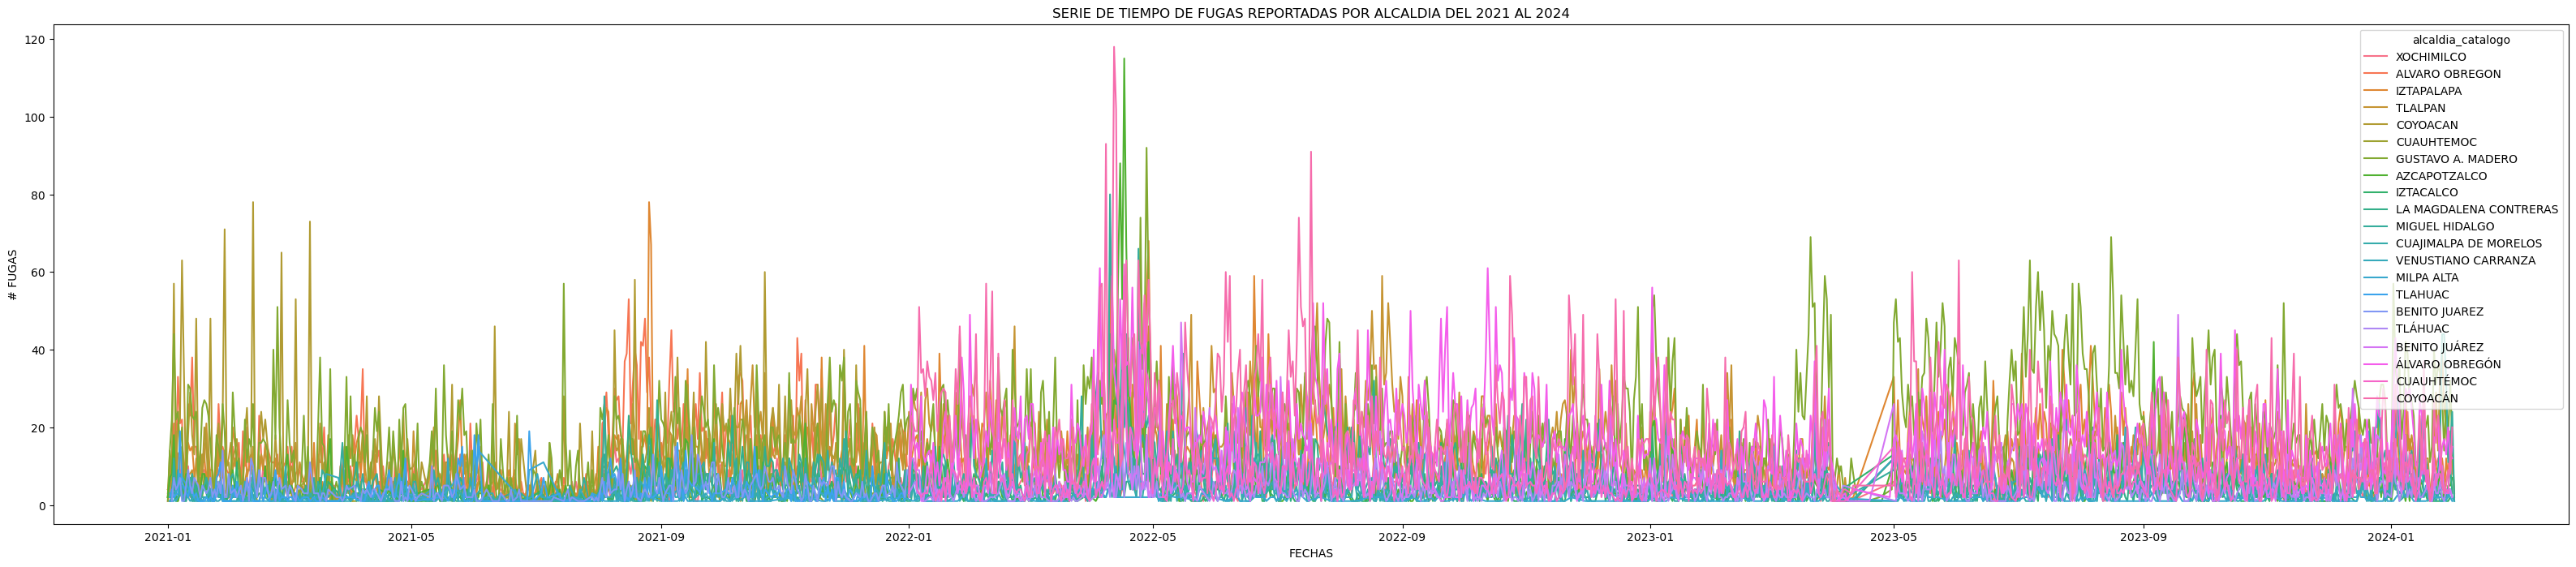

In [10]:
# Grafico general en serie de tiempo
fig, ax = plt.subplots(figsize=(40, 8))

g = sns.lineplot(df_por_fecha, x='fecha_reporte', y='total_fugas', hue='alcaldia_catalogo', ax=ax)
sns.move_legend(ax, "upper right")

g.set(
    xlabel="Fechas".upper(),
    ylabel="# Fugas".upper(),
    title="serie de tiempo de fugas reportadas por alcaldia del 2021 al 2024".upper()
)
plt.show()

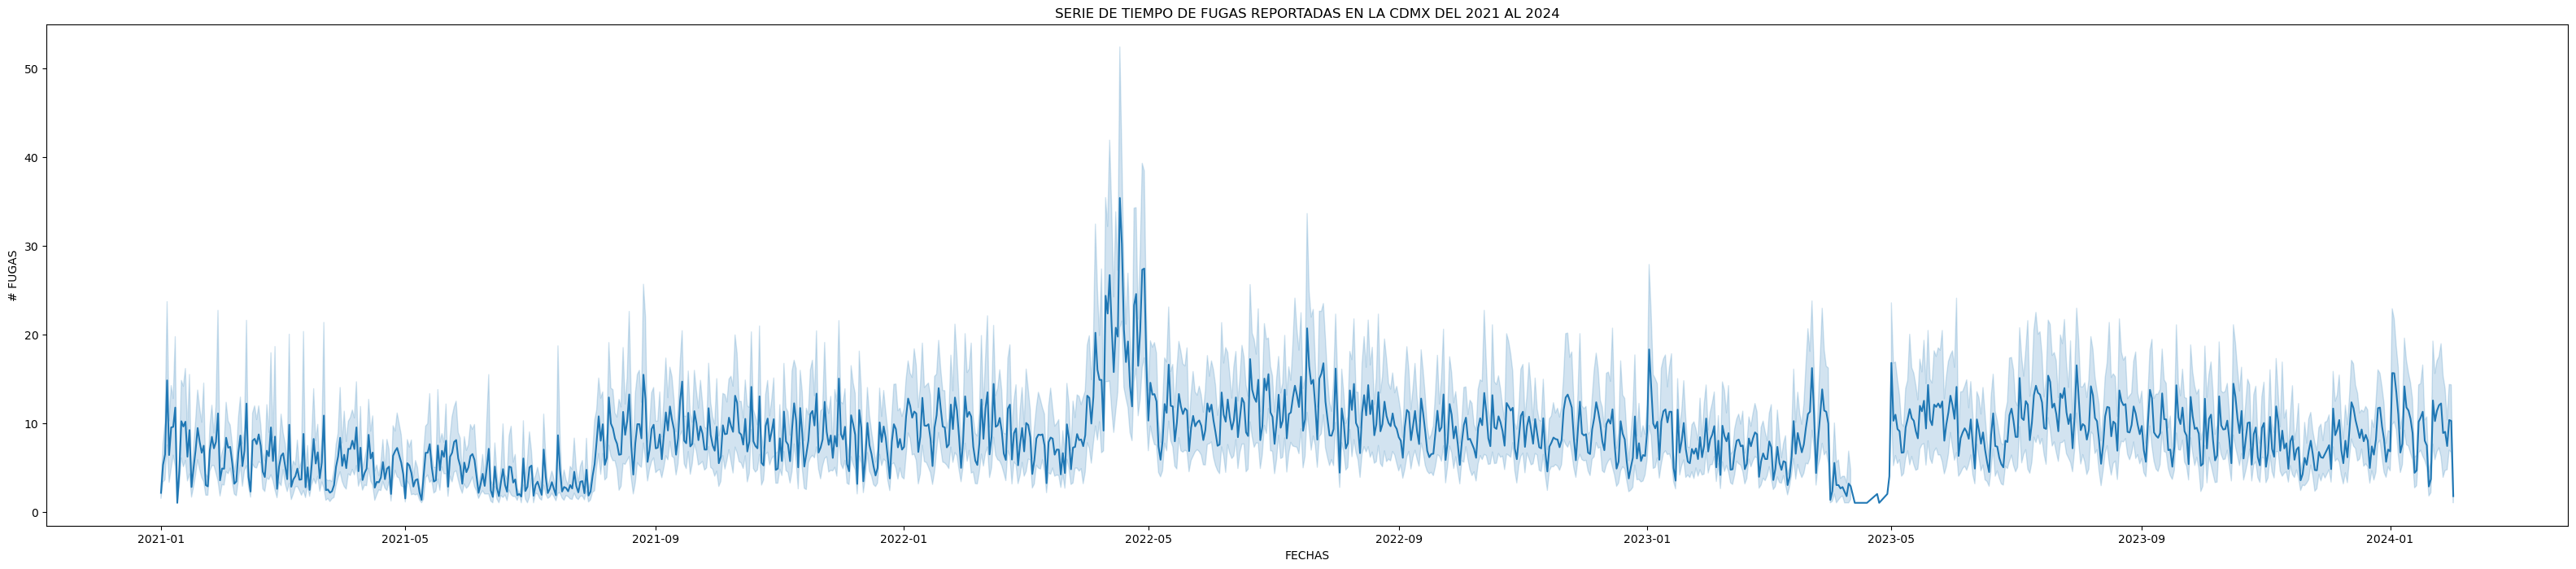

In [13]:
# Grafico general en serie de tiempo
fig, ax = plt.subplots(figsize=(40, 8))

g = sns.lineplot(df_por_fecha, x='fecha_reporte', y='total_fugas', ax=ax)

g.set(
    xlabel="Fechas".upper(),
    ylabel="# Fugas".upper(),
    title="serie de tiempo de fugas reportadas en la CDMX del 2021 al 2024".upper()
)
plt.show()

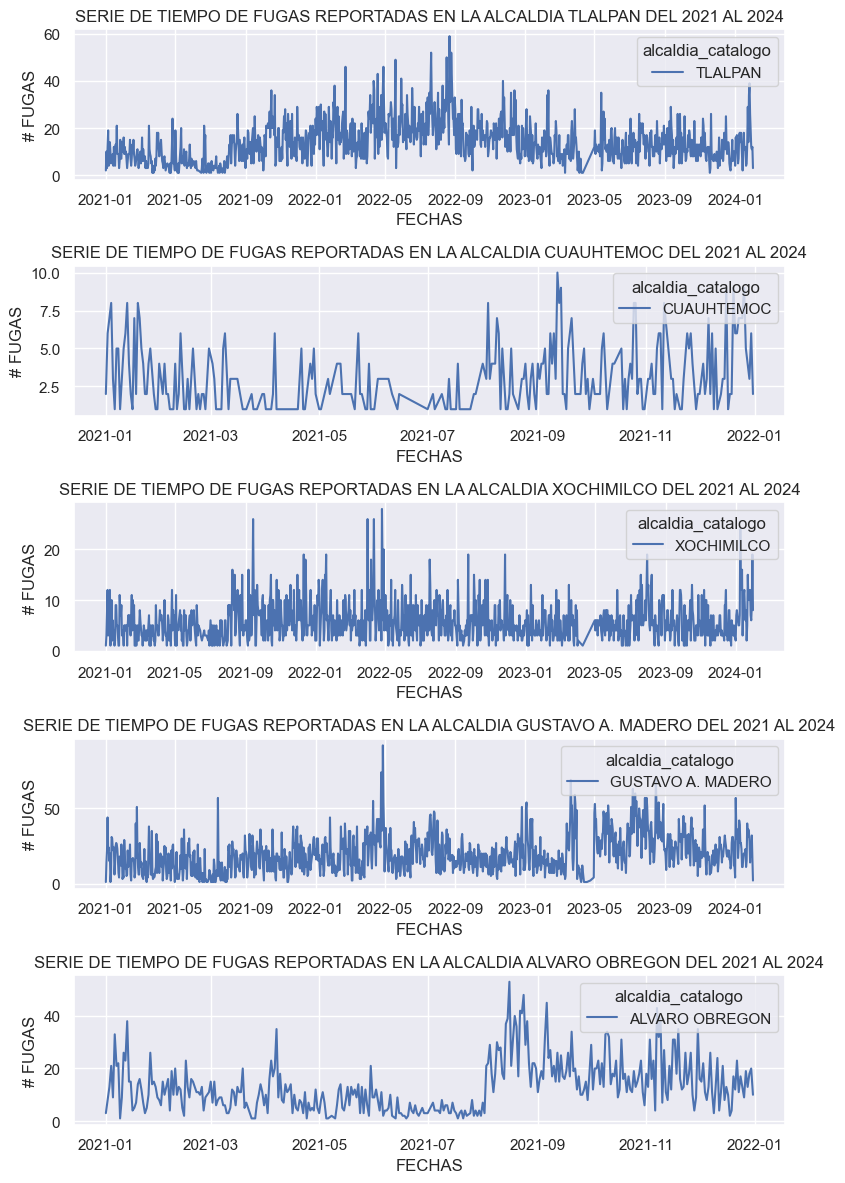

In [45]:
# Grafico por delegación
delegaciones = df_por_fecha['alcaldia_catalogo'].unique().tolist()
# Primeras 5 de la lista
fig, axes = plt.subplots(5, 1, figsize=(8, 12))
for delegacion, ax in zip(delegaciones[:5], axes):
    data = df_por_fecha[df_por_fecha.alcaldia_catalogo == delegacion]
    g = sns.lineplot(data, x='fecha_reporte', y='total_fugas', hue='alcaldia_catalogo', ax=ax)
    sns.move_legend(ax, "upper right")

    g.set(
        xlabel="Fechas".upper(),
        ylabel="# Fugas".upper(),
        title=f"serie de tiempo de fugas reportadas en la alcaldia {delegacion} del 2021 al 2024".upper()
    )
plt.tight_layout()
plt.show()

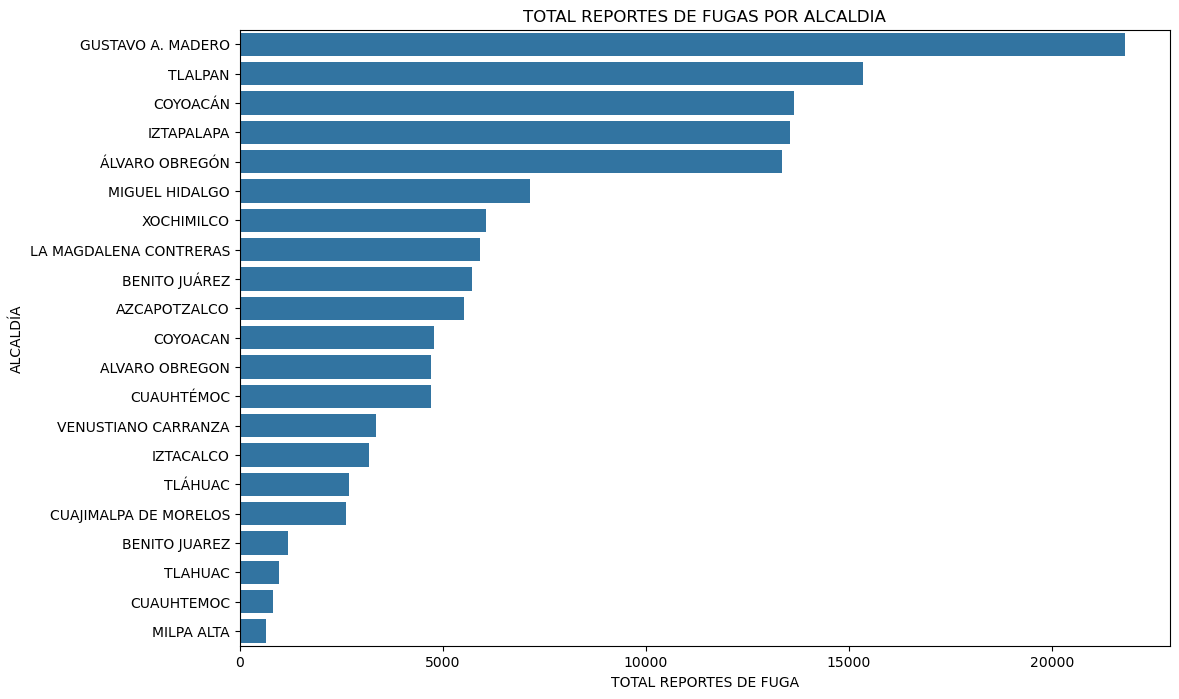

In [14]:
# Grafico barras horizontales
alcaldias_reportes = df_por_fecha.groupby('alcaldia_catalogo', as_index=False)['total_fugas'].sum().sort_values('total_fugas', ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

g = sns.barplot(alcaldias_reportes, 
            y='alcaldia_catalogo', 
            x='total_fugas', 
            orient='h',
            ax=ax)

g.set(xlabel="Total reportes de fuga".upper(), ylabel="alcaldía".upper(), title="Total reportes de fugas por alcaldia".upper())

plt.show()

In [15]:
# Seleccionamos las 3 alcaldias con mas casos de fugas
df_gam = df_por_fecha[(df_por_fecha.alcaldia_catalogo == "GUSTAVO A. MADERO") & (df_por_fecha.fecha_reporte.dt.year != 2024)]
df_tla = df_por_fecha[(df_por_fecha.alcaldia_catalogo == "TLALPAN") & (df_por_fecha.fecha_reporte.dt.year != 2024)]
df_coy = df_por_fecha[(df_por_fecha.alcaldia_catalogo == "COYOACAN") & (df_por_fecha.fecha_reporte.dt.year != 2024)]

In [16]:
df_gam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1075 entries, 6 to 15040
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fecha_reporte      1075 non-null   datetime64[ms]
 1   alcaldia_catalogo  1075 non-null   object        
 2   total_fugas        1075 non-null   uint32        
dtypes: datetime64[ms](1), object(1), uint32(1)
memory usage: 29.4+ KB


In [17]:
df_coy.info()
print("")
df_tla.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350 entries, 4 to 4720
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fecha_reporte      350 non-null    datetime64[ms]
 1   alcaldia_catalogo  350 non-null    object        
 2   total_fugas        350 non-null    uint32        
dtypes: datetime64[ms](1), object(1), uint32(1)
memory usage: 9.6+ KB

<class 'pandas.core.frame.DataFrame'>
Index: 1060 entries, 3 to 15033
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fecha_reporte      1060 non-null   datetime64[ms]
 1   alcaldia_catalogo  1060 non-null   object        
 2   total_fugas        1060 non-null   uint32        
dtypes: datetime64[ms](1), object(1), uint32(1)
memory usage: 29.0+ KB


In [18]:
# Seteamos la fecha como indice
df_coy.set_index("fecha_reporte", inplace=True)
df_tla.set_index("fecha_reporte", inplace=True)
df_gam.set_index("fecha_reporte", inplace=True)

In [19]:
# Ordenamos los indices
df_gam.sort_index(inplace=True)
df_tla.sort_index(inplace=True)
df_coy.sort_index(inplace=True)

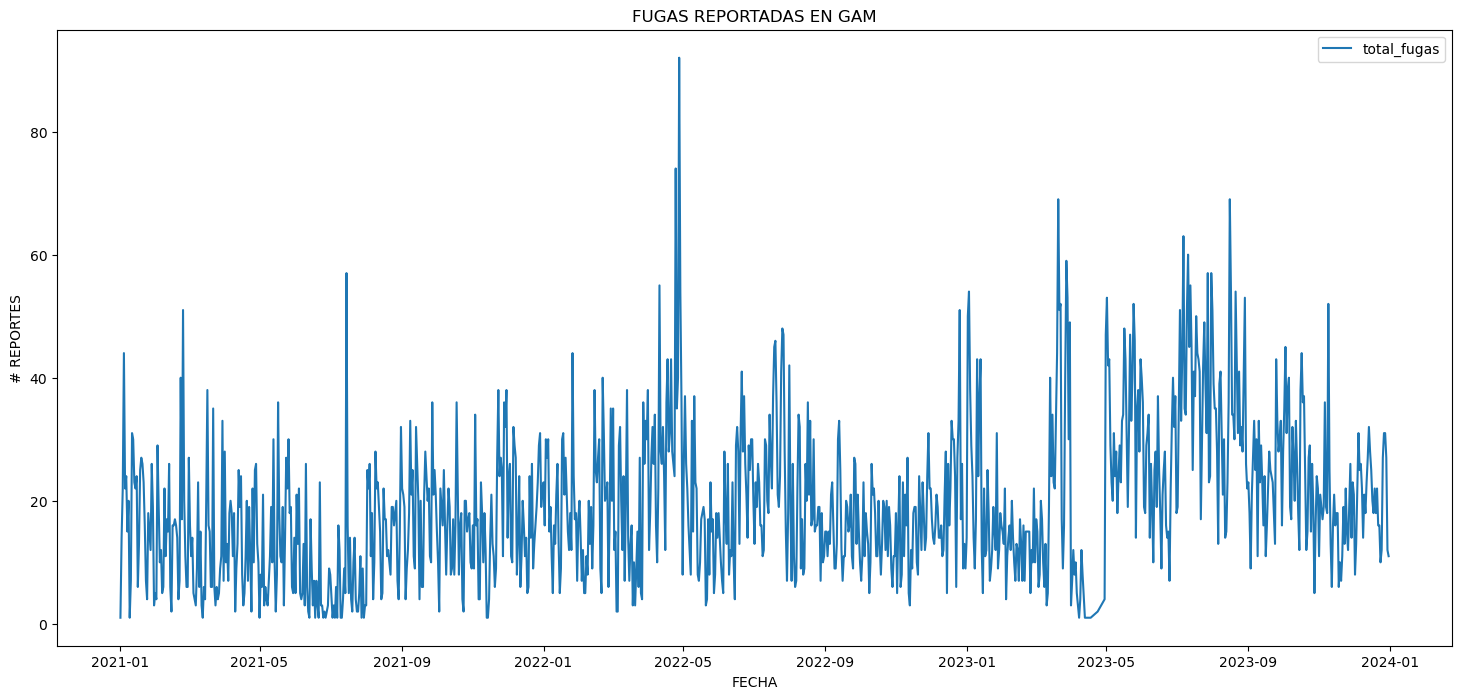

In [20]:
fig, ax = plt.subplots(figsize=(18, 8))
g = sns.lineplot(df_gam, ax=ax)
# df_gam.iloc[0:350].plot(figsize=(30,10), title='Fugas reportadas'.upper())
g.set(
    xlabel="fecha".upper(),
    ylabel="# Reportes".upper(),
    title='Fugas reportadas en GAM'.upper()
)
plt.show()

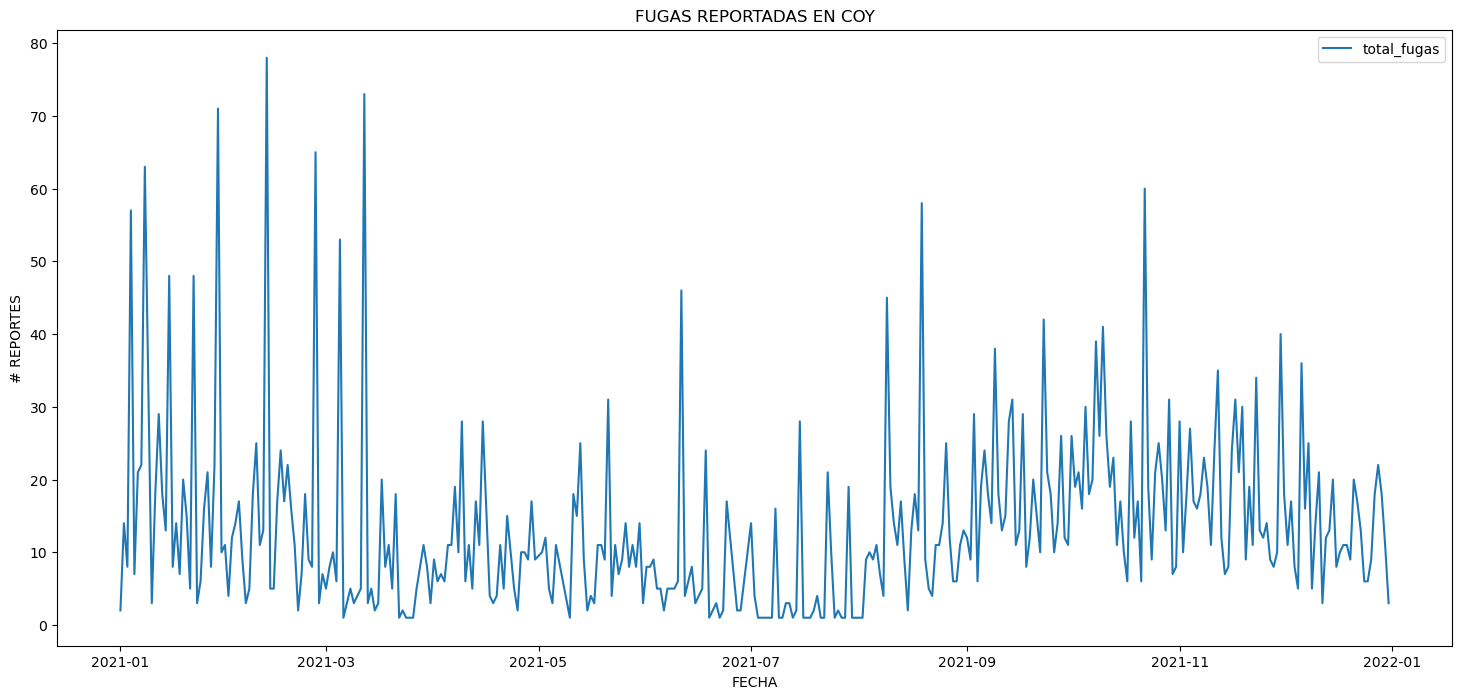

In [21]:
fig, ax = plt.subplots(figsize=(18, 8))
g = sns.lineplot(df_coy, ax=ax)
# df_gam.iloc[0:350].plot(figsize=(30,10), title='Fugas reportadas'.upper())
g.set(
    xlabel="fecha".upper(),
    ylabel="# Reportes".upper(),
    title='Fugas reportadas en COY'.upper()
)
plt.show()

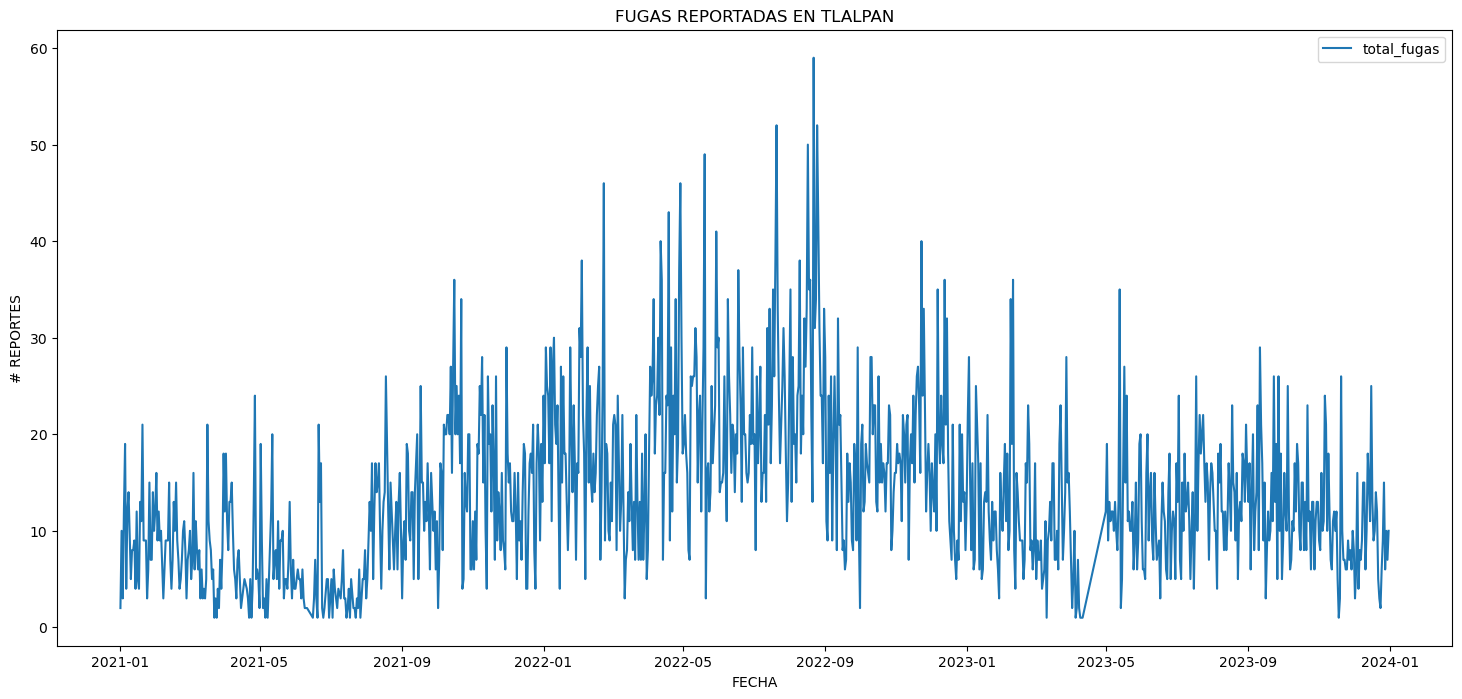

In [22]:
fig, ax = plt.subplots(figsize=(18, 8))
g = sns.lineplot(df_tla, ax=ax)
# df_gam.iloc[0:350].plot(figsize=(30,10), title='Fugas reportadas'.upper())
g.set(
    xlabel="fecha".upper(),
    ylabel="# Reportes".upper(),
    title='Fugas reportadas en TLALPAN'.upper()
)
plt.show()

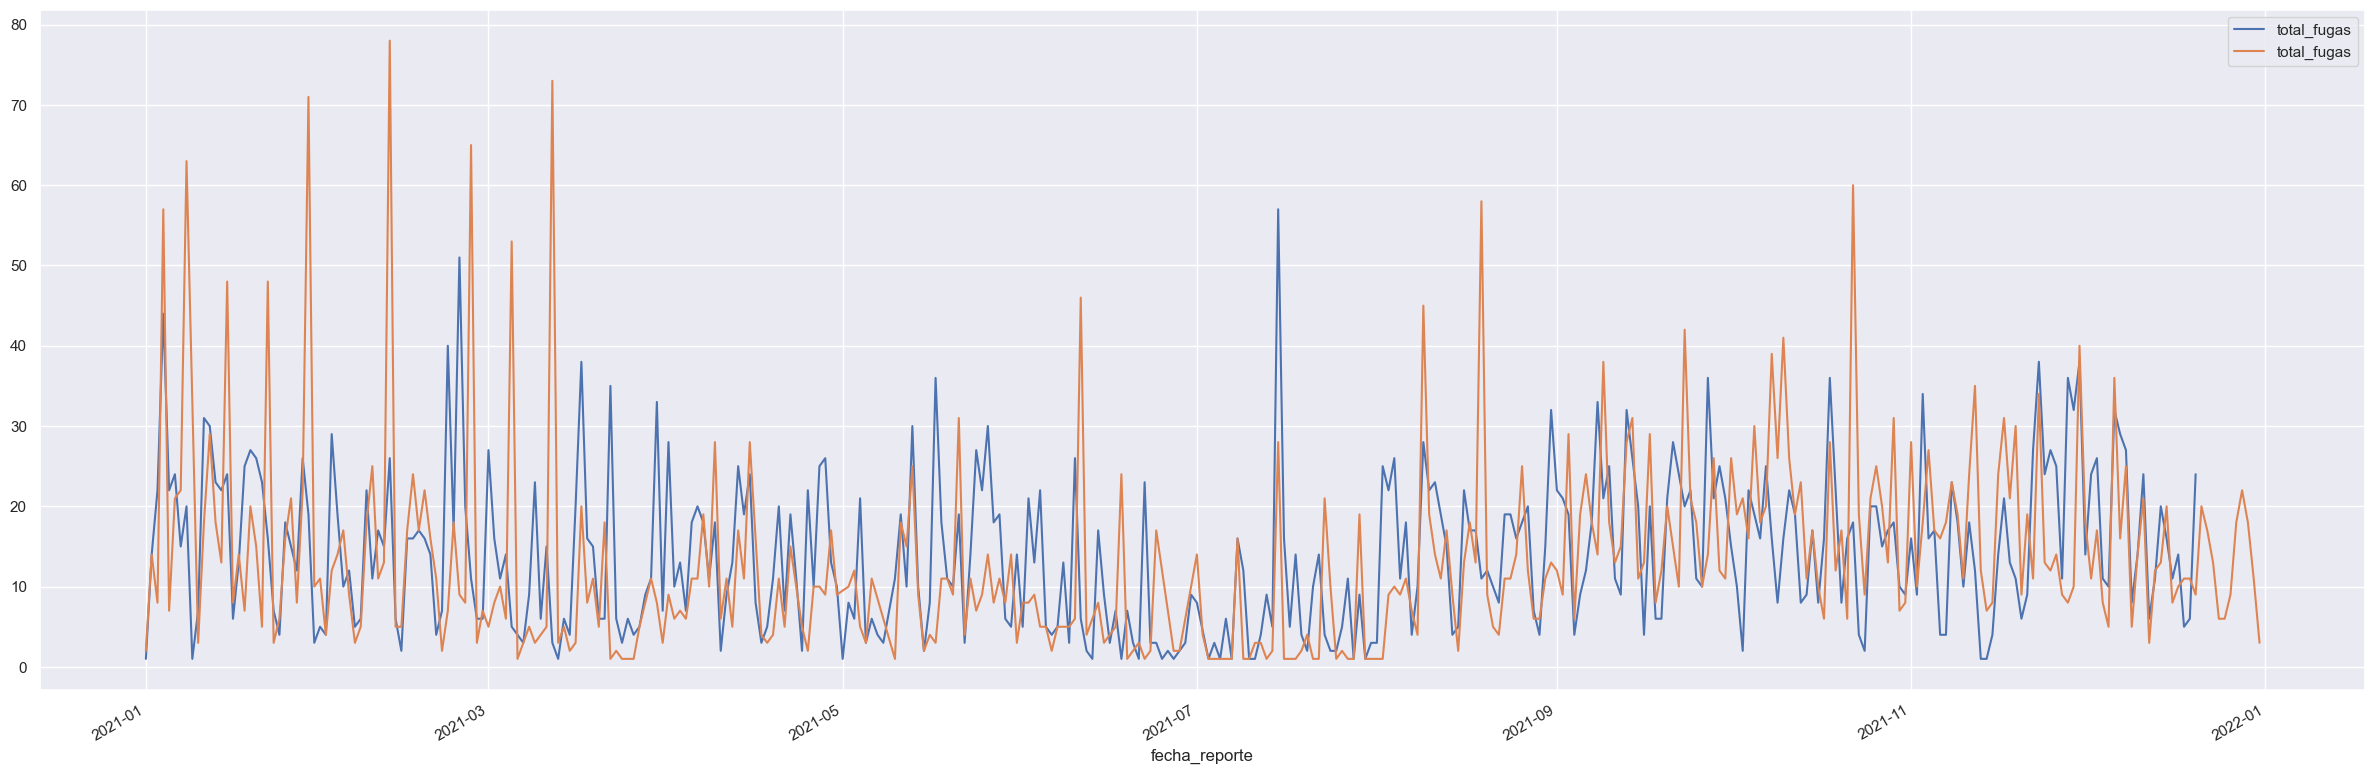

In [56]:
fig, ax = plt.subplots()

df_gam.iloc[0:350].plot(ax=ax, figsize=(30,10))
df_coy.iloc[0:350].plot(ax=ax, figsize=(30,10))
plt.show()

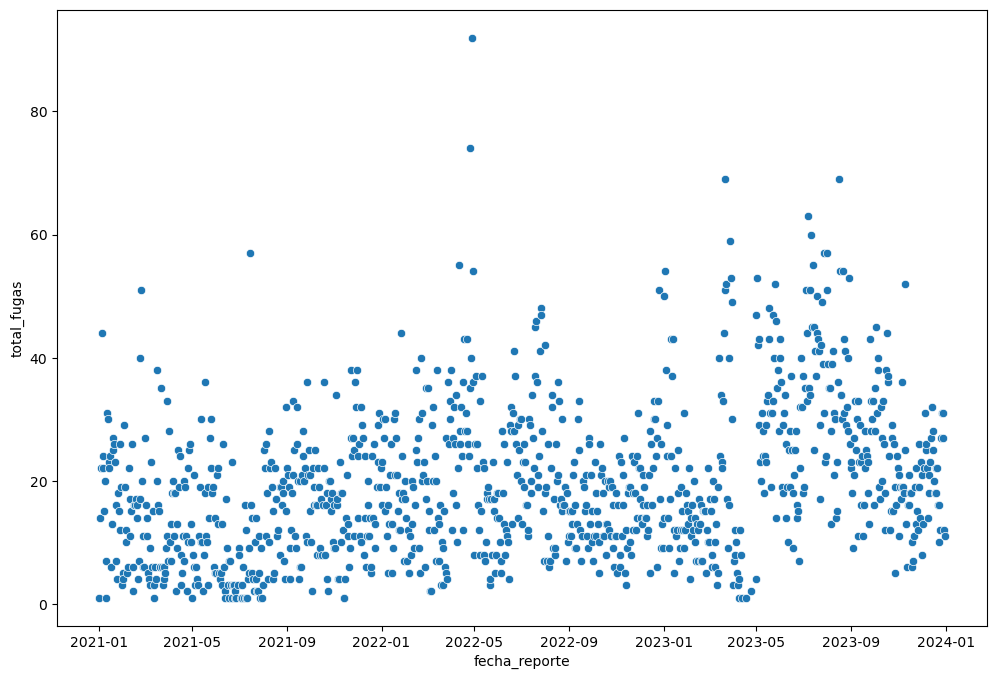

In [23]:
# Grafico de dispersión
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(df_gam, x="fecha_reporte", y="total_fugas", ax=ax)
plt.show()

In [24]:
df_por_fecha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15500 entries, 0 to 15499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fecha_reporte      15500 non-null  datetime64[ms]
 1   alcaldia_catalogo  15500 non-null  object        
 2   total_fugas        15500 non-null  uint32        
dtypes: datetime64[ms](1), object(1), uint32(1)
memory usage: 302.9+ KB


In [238]:
df_gam.sort_index(inplace=True)

# Test ADF

In [25]:
# Probar estacionariedad
result = sts.adfuller(df_gam.total_fugas)
print("<----- {} ------>".format("GAM"))
print('Estadístico ADF:', result[0])
print('p-value:', result[1])
print('Valores críticos:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

<----- GAM ------>
Estadístico ADF: -3.9685010941659864
p-value: 0.0015847333988030007
Valores críticos:
	1%: -3.436581300425998
	5%: -2.8642912936257905
	10%: -2.5682348955818357


In [26]:
result = sts.adfuller(df_coy.total_fugas)
print("<----- {} ------>".format("COY"))
print('Estadístico ADF:', result[0])
print('p-value:', result[1])
print('Valores críticos:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

<----- COY ------>
Estadístico ADF: -2.5801951762895365
p-value: 0.09715999533812486
Valores críticos:
	1%: -3.449962981927952
	5%: -2.870180642420163
	10%: -2.5713734527352607


In [27]:
result = sts.adfuller(df_tla.total_fugas)
print("<----- {} ------>".format("TLA"))
print('Estadístico ADF:', result[0])
print('p-value:', result[1])
print('Valores críticos:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

<----- TLA ------>
Estadístico ADF: -2.6267977760226415
p-value: 0.08758422105565311
Valores críticos:
	1%: -3.436659460539809
	5%: -2.864325767240336
	10%: -2.5682532565554537


In [28]:
# cambiamos la frecuencia
# LLenamos los dias vacios o nulos con 0
df_gam = df_gam.resample('d').asfreq(fill_value=0)
# df_gam = df_gam.fillna(0)

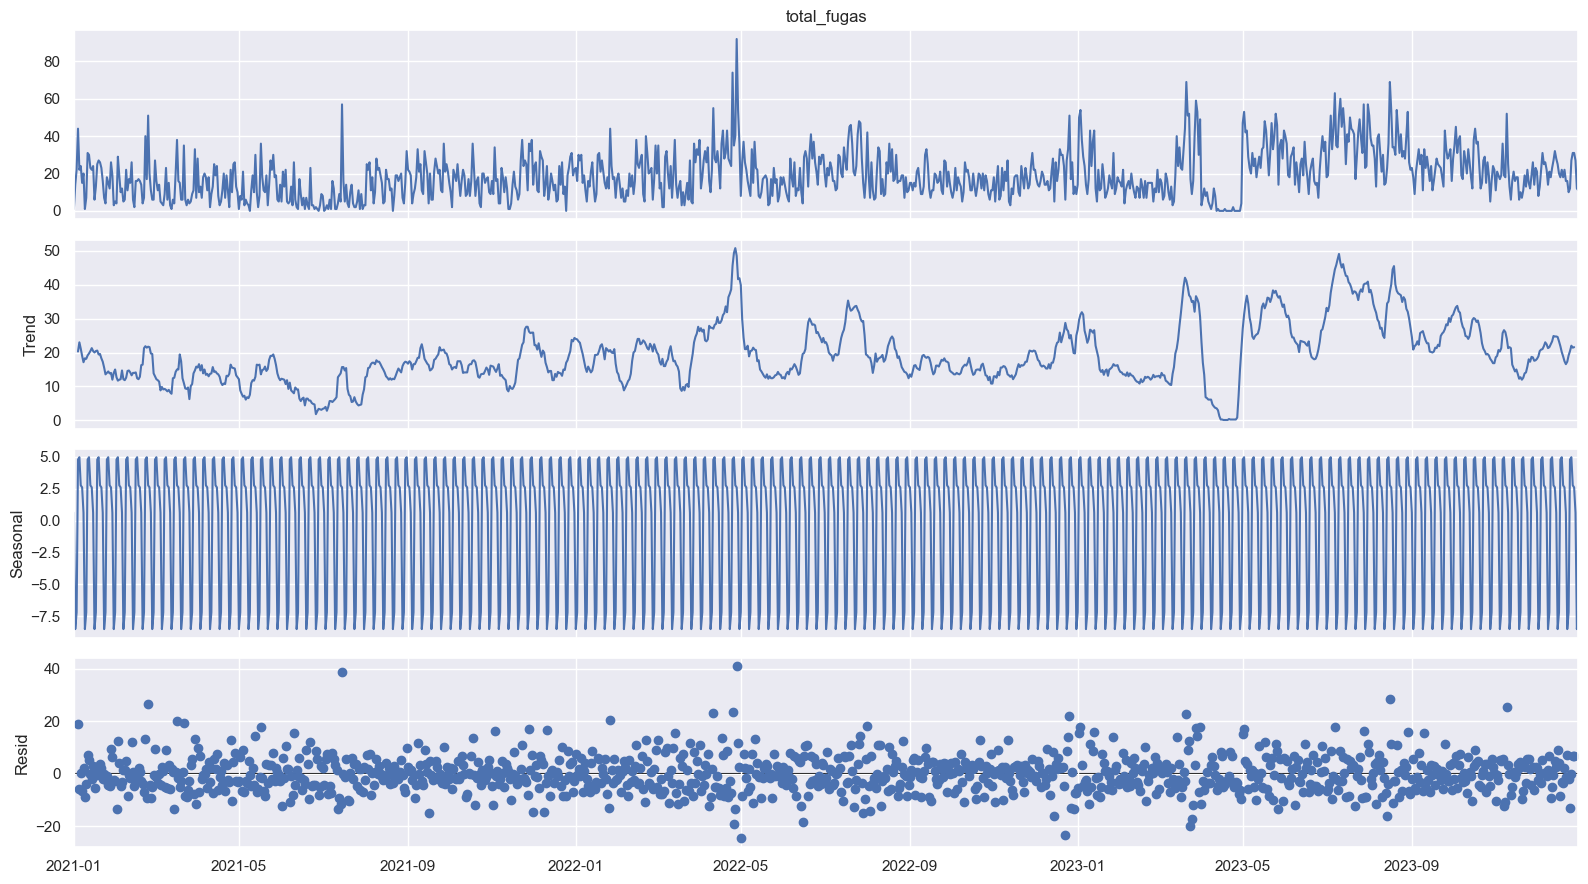

In [41]:
# Descomponemos la serie para ver sus componentes
decompose_result_add = seasonal_decompose(df_gam.total_fugas, model='additive')
fig = decompose_result_add.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

In [30]:
# Dara error, ya que el multiplicativo requiere que no haya valores en 0 o negativos
decompose_result_mult = seasonal_decompose(df_gam.total_fugas, model='multiplicative')
fig = decompose_result_mult.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

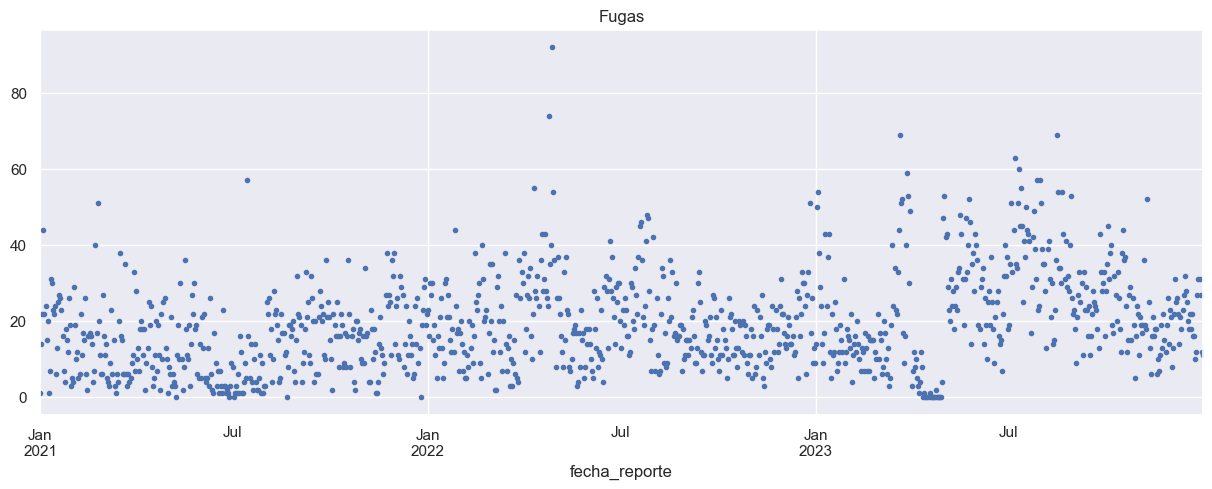

In [68]:
df_gam.total_fugas.plot(style='.',
        figsize=(15, 5),
        title='Fugas')
plt.show()

### Ajuste del modelo por estacionalidades

In [31]:
# Asignamos la frecuencia por mes
df_gam_monthly_agg = df_gam.total_fugas.resample('M').agg(['sum', 'mean', 'std'])
df_gam_monthly_agg.columns = ['total_fugas', 'avg_fugas', 'std_fugas']
df_gam_monthly_agg.loc[:, "alcaldia"] = "GUSTAVO A. MADERO"

In [110]:
df_gam_monthly_agg.head()

total_fugas  avg_fugas  std_fugas           alcaldia  \
fecha_reporte                                                         
2021-01-31             545  17.580645  10.115250  GUSTAVO A. MADERO   
2021-02-28             425  15.178571  11.068988  GUSTAVO A. MADERO   
2021-03-31             367  11.838710  10.040242  GUSTAVO A. MADERO   
2021-04-30             427  14.233333   7.523221  GUSTAVO A. MADERO   
2021-05-31             394  12.709677   9.515579  GUSTAVO A. MADERO   

               total_fugas_1  total_fugas_ADD  total_fugas_MUL     TF3_ADD  \
fecha_reporte                                                                
2021-01-31        545.000000       403.703490       420.023803  454.869774   
2021-02-28        545.000000       429.292615       442.134721  274.985558   
2021-03-31        540.000000       441.788244       450.183247  477.164063   
2021-04-30        532.791667       447.417701       451.074203  370.762434   
2021-05-31        528.383681       457.777591       457.788456  573.257054   

                  TF3_MUL  
fecha_reporte              
2021-01-31     456.680405  
2021-02-28     326.444135  
2021-03-31     529.281807  
2021-04-30     468.254940  
2021-05-31     632.821468

In [33]:
# Corroborar si coincide el dato
df_gam[(df_gam.index.month == 1) & (df_gam.index.year == 2021)].total_fugas.sum()

545

In [34]:
df_gam[(df_gam.index.month == 2) & (df_gam.index.year == 2021)]['total_fugas'].sum()

425

In [37]:
# Set the value of Alpha and define m (Time Period)
m = 12
alpha = 1/(2*m)

#### Single HWES

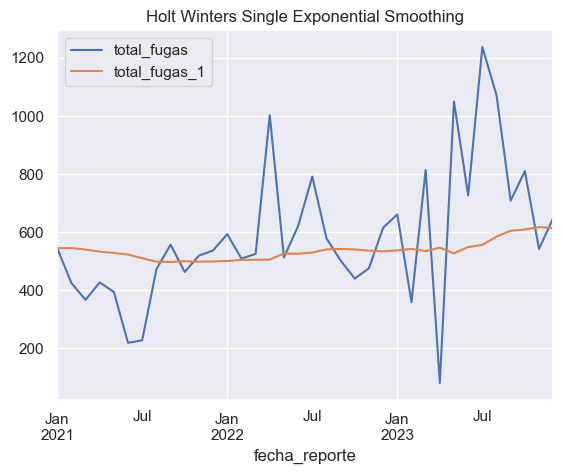

In [42]:
df_gam_monthly_agg.loc[:, 'total_fugas_1'] = SimpleExpSmoothing(df_gam_monthly_agg.total_fugas).fit(smoothing_level=alpha, optimized=False, use_brute=True).fittedvalues
df_gam_monthly_agg[['total_fugas','total_fugas_1']].plot(title='Holt Winters Single Exponential Smoothing')
plt.show()

#### Double HWES

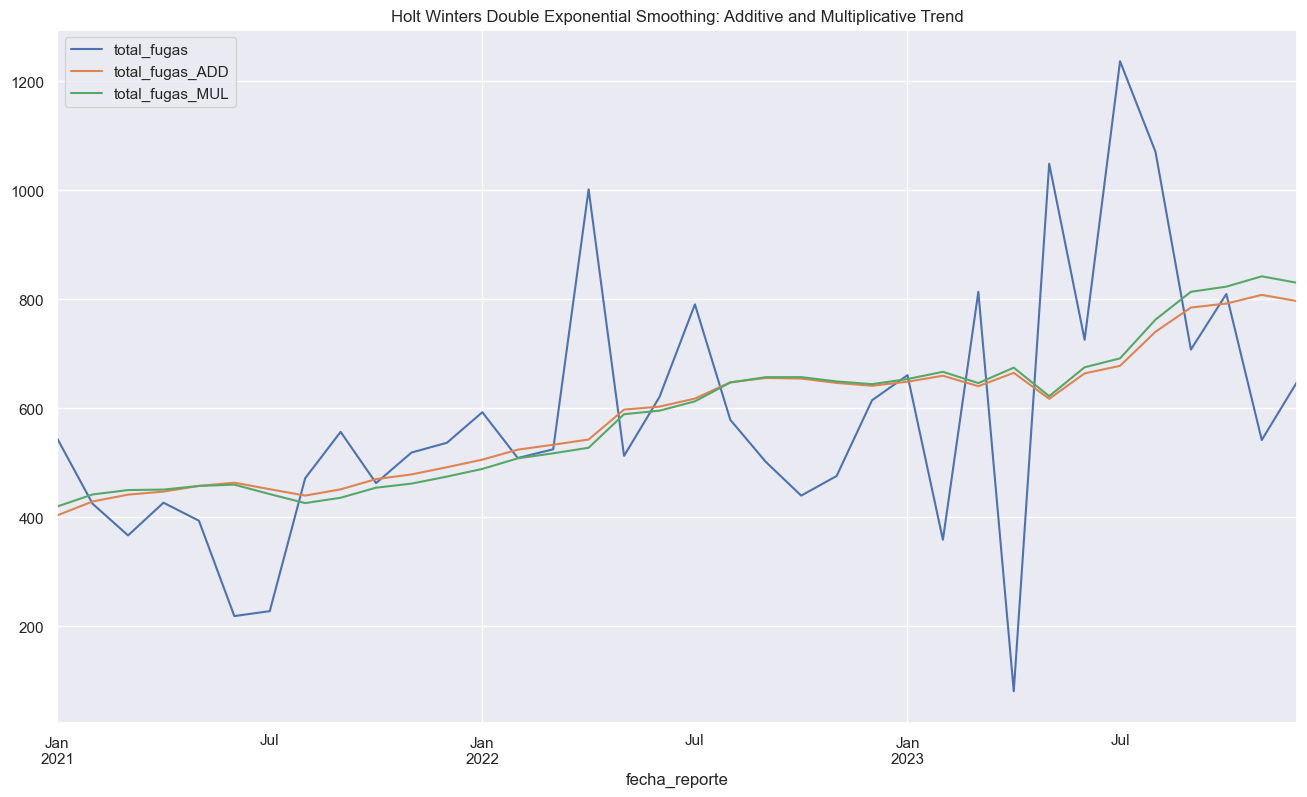

In [43]:
df_gam_monthly_agg.loc[:, 'total_fugas_ADD'] = ExponentialSmoothing(df_gam_monthly_agg.total_fugas, trend='add').fit().fittedvalues
df_gam_monthly_agg.loc[:, 'total_fugas_MUL'] = ExponentialSmoothing(df_gam_monthly_agg.total_fugas, trend='mul').fit().fittedvalues
fig = df_gam_monthly_agg[['total_fugas','total_fugas_ADD','total_fugas_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend', figsize=(16, 9))
# fig.set_size_inches((16, 9))
# Tight layout to realign things
# fig.tight_layout()
plt.show()

#### Triple HWES

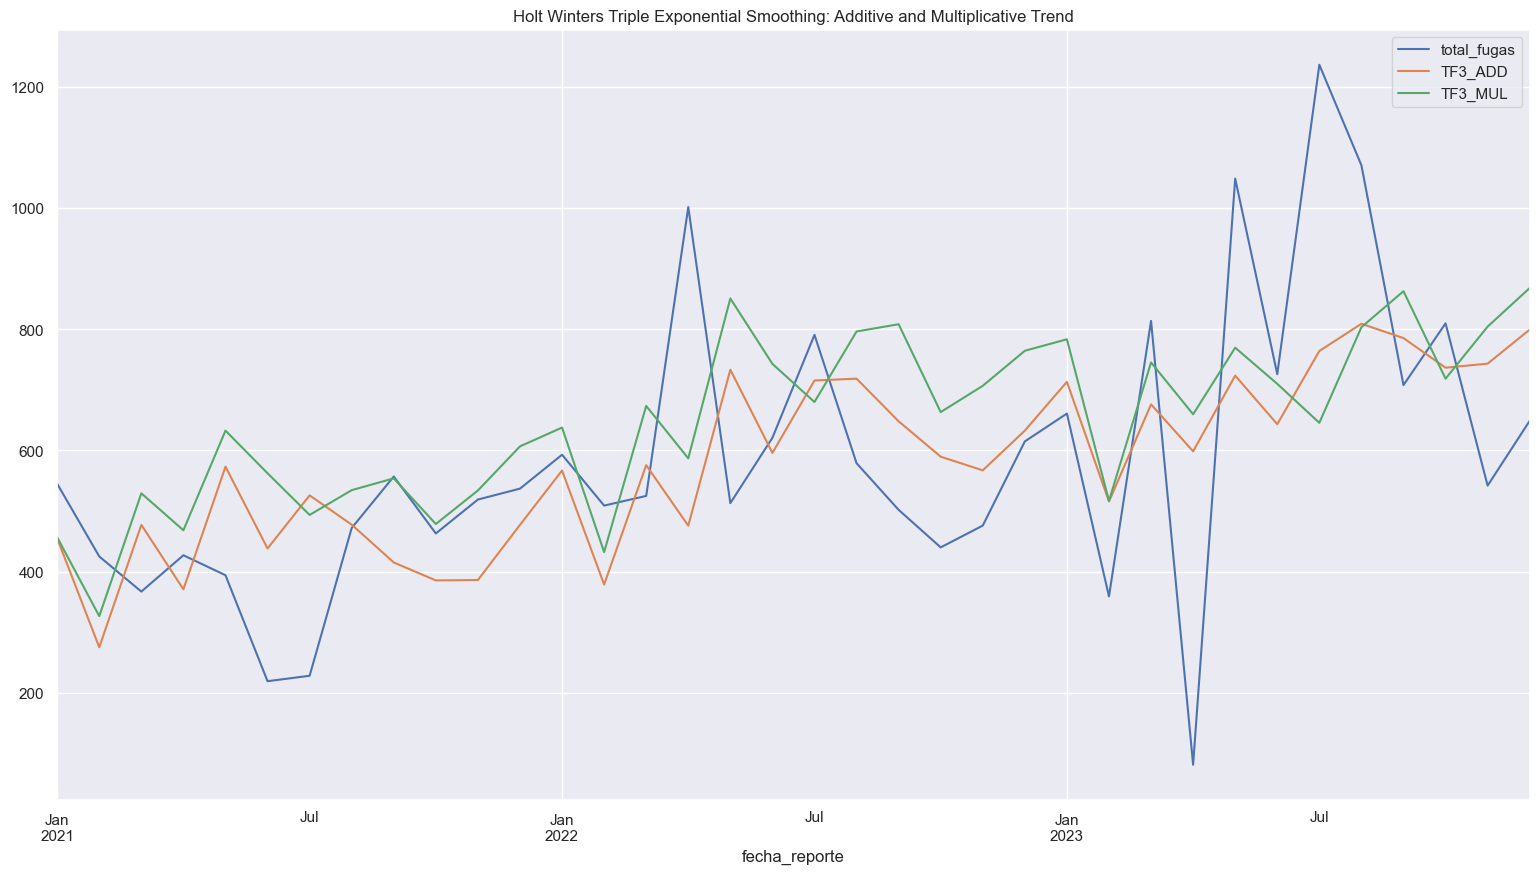

In [44]:
df_gam_monthly_agg.loc[:, 'TF3_ADD'] = ExponentialSmoothing(df_gam_monthly_agg.total_fugas, trend='add', seasonal='add', seasonal_periods=12).fit().fittedvalues
df_gam_monthly_agg.loc[:, 'TF3_MUL'] = ExponentialSmoothing(df_gam_monthly_agg.total_fugas, trend='mul', seasonal='mul', seasonal_periods=12).fit().fittedvalues
df_gam_monthly_agg[['total_fugas','TF3_ADD','TF3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Trend', figsize=(19, 10))
plt.show()

#### Ajustando el modelo

In [51]:
# Tamaño de los datos de entrenamiento
size = int(len(df_gam_monthly_agg)*0.5)
size

18

In [57]:
# Split into train and test set
train_des = df_gam_monthly_agg[size:]
test_des = df_gam_monthly_agg[:size]

In [56]:
test_predictions

2022-07-31     663.069368
2022-08-31     676.671995
2022-09-30     694.318961
2022-10-31     935.289009
2022-11-30     673.591445
2022-12-31     659.821607
2023-01-31     771.014060
2023-02-28     783.921186
2023-03-31     801.532961
2023-04-30    1076.089024
2023-05-31     772.513087
2023-06-30     754.405987
2023-07-31     878.958753
2023-08-31     891.170378
2023-09-30     908.746961
2023-10-31    1216.889039
2023-11-30     871.434729
2023-12-31     848.990368
Freq: ME, dtype: float64

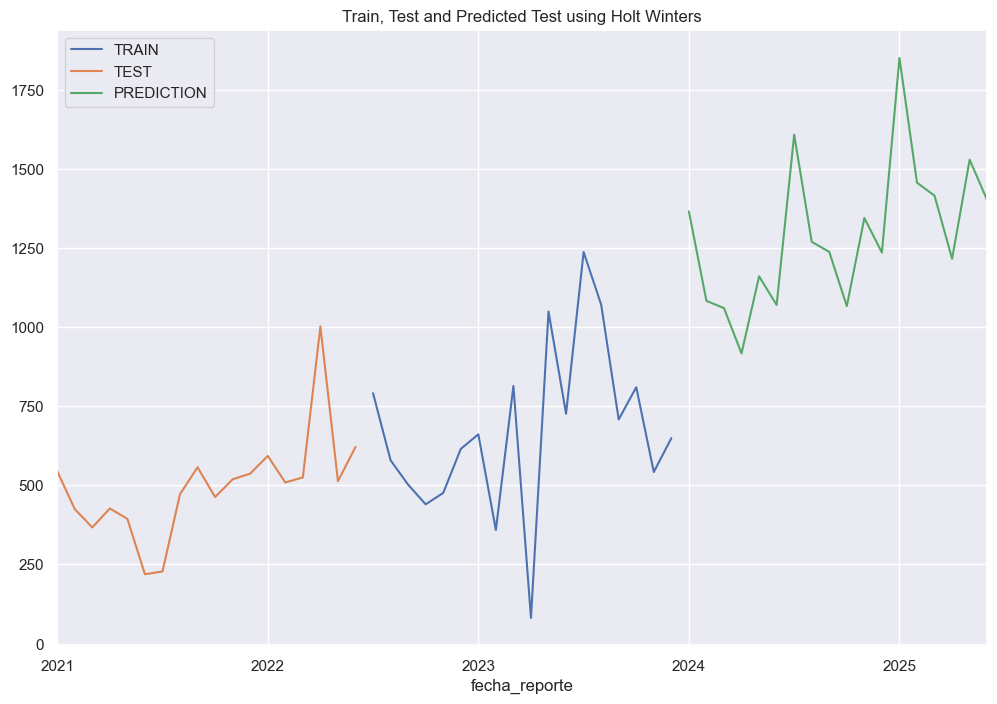

In [58]:
fig, ax = plt.subplots(figsize=(12, 8))

fitted_model = ExponentialSmoothing(train_des['total_fugas'], trend='add', seasonal='mul', seasonal_periods=6).fit()
test_predictions = fitted_model.forecast(18)
train_des['total_fugas'].plot(legend=True, label='TRAIN', ax=ax)
test_des['total_fugas'].plot(legend=True, label='TEST', ax=ax)
test_predictions.plot(legend=True, label='PREDICTION', ax=ax)
plt.title('Train, Test and Predicted Test using Holt Winters')

plt.show()

In [63]:
# Tamaño de los datos de entrenamiento
size = int(len(df_gam_monthly_agg)*0.7)
size

25

In [ ]:
# Split into train and test set
train_des = df_gam_monthly_agg[size:]
test_des = df_gam_monthly_agg[:size]

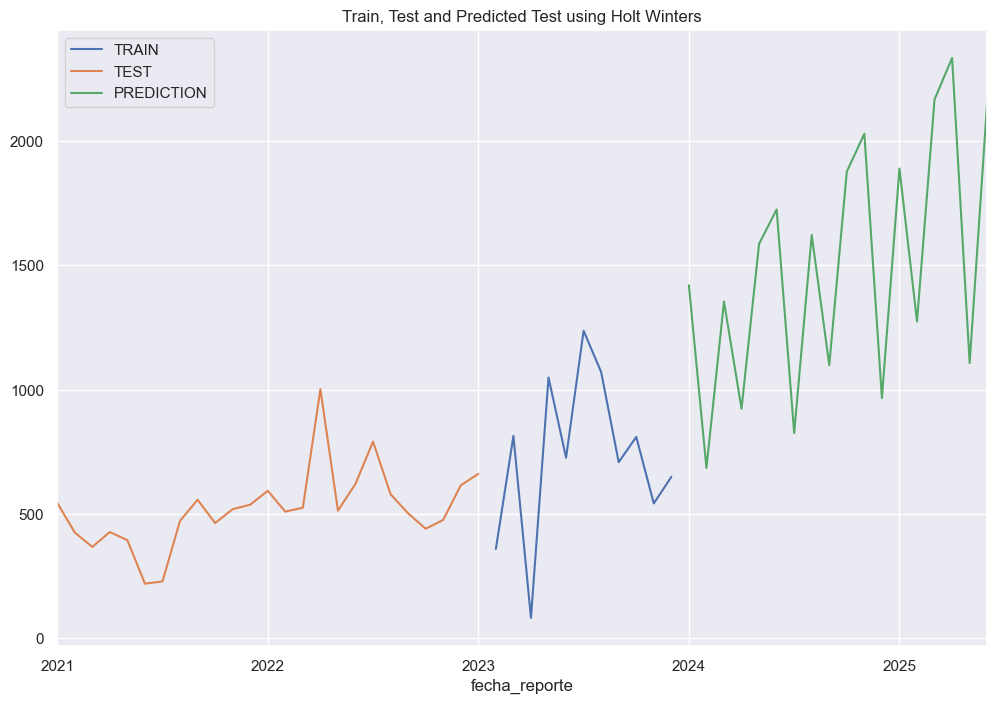

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))

fitted_model = ExponentialSmoothing(train_des['total_fugas'], trend='add', seasonal='mul', seasonal_periods=5).fit()
test_predictions = fitted_model.forecast(18)
train_des['total_fugas'].plot(legend=True, label='TRAIN', ax=ax)
test_des['total_fugas'].plot(legend=True, label='TEST', ax=ax)
test_predictions.plot(legend=True, label='PREDICTION', ax=ax)
plt.title('Train, Test and Predicted Test using Holt Winters')

plt.show()

# Forecasting

In [77]:
size = int(len(df_gam)*0.4)
train_des = df_gam[size:] # 80% datos entrenamiento
test_des = df_gam[:size] # 20% datos de prueba

In [78]:
train_des.shape

(657, 2)

In [79]:
test_des.shape

(438, 2)

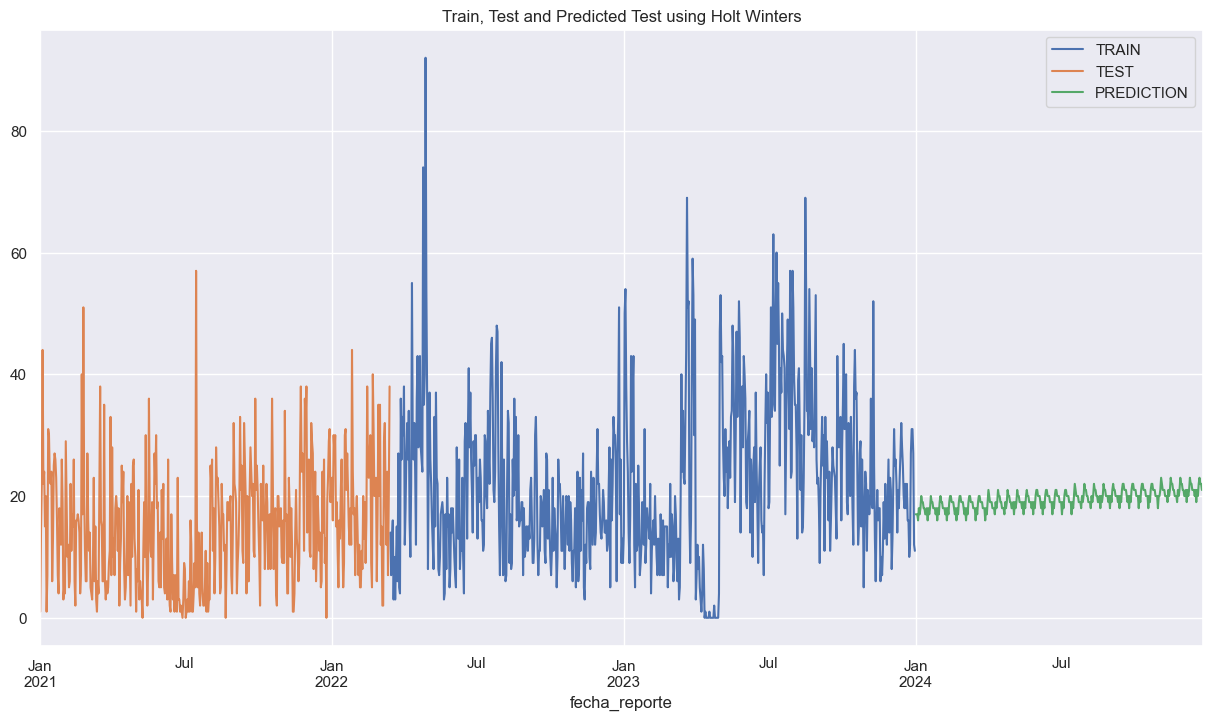

In [90]:
# Suavizado exponencial
fig, ax = plt.subplots(figsize=(15,8))
# Se selecciona el additivo, ya que tenemos dias con 0 reportes
fitted_model = ExponentialSmoothing(train_des['total_fugas'], trend='add', seasonal='add', seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(360).round(0)
train_des['total_fugas'].plot(legend=True, label='TRAIN', ax=ax)
test_des['total_fugas'].plot(legend=True,label='TEST', ax=ax)
test_predictions.plot(legend=True,label='PREDICTION', ax=ax)
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()

ValueError: endog must be strictly positive when usingmultiplicative trend or seasonal components.

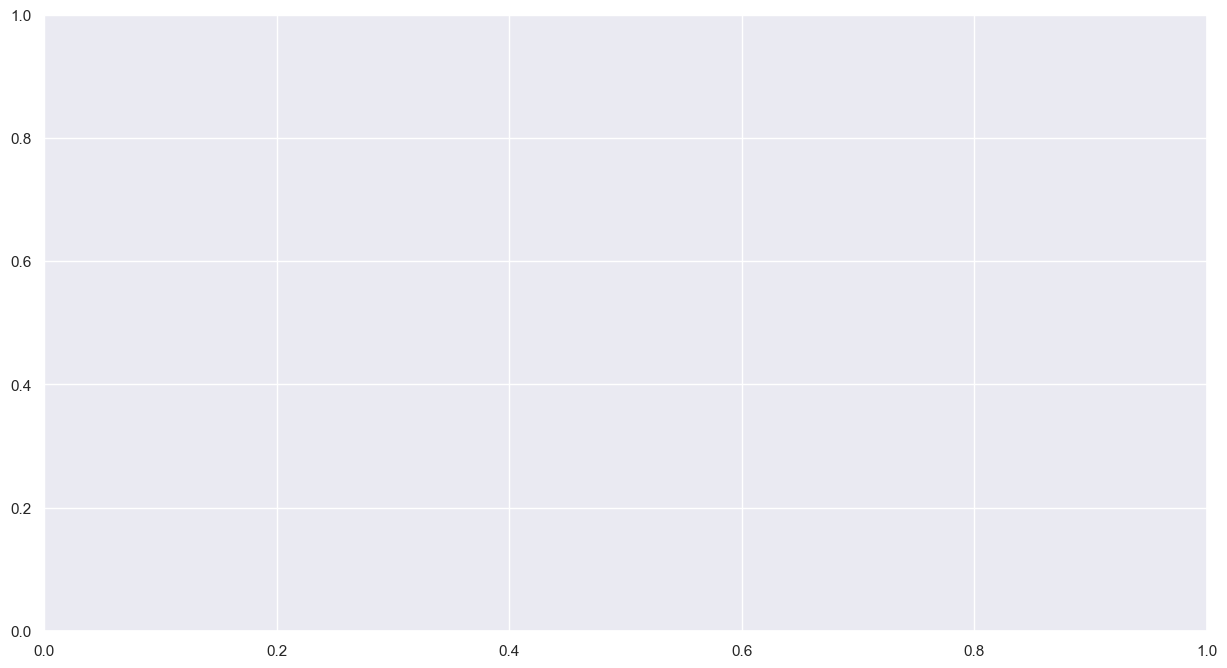

In [ ]:
# Fallara ya que tenemos valores en 0, podriamos usar ffill junto con round para evitar decimales.
# Suavizado exponencial con mult dara error debido a que tenemos valores en 0
fig, ax = plt.subplots(figsize=(15,8))
fitted_model = ExponentialSmoothing(df_gam['total_fugas'], trend='mul', seasonal='mul', seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(40)
train_des['total_fugas'].plot(legend=True, label='TRAIN', ax=ax)
test_des['total_fugas'].plot(legend=True,label='TEST', ax=ax)
test_predictions.plot(legend=True,label='PREDICTION', ax=ax)
plt.title('Train, Test and Predicted Test usando Holt Winters'.upper())
plt.show()

In [118]:
test_predictions.round(0)

2023-05-27    42.0
2023-05-28    42.0
2023-05-29    42.0
2023-05-30    44.0
2023-05-31    42.0
              ... 
2024-05-16    52.0
2024-05-17    53.0
2024-05-18    52.0
2024-05-19    53.0
2024-05-20    54.0
Freq: D, Length: 360, dtype: float64

In [74]:
df_gam_2024 = df_por_fecha[(df_por_fecha.alcaldia_catalogo == "GUSTAVO A. MADERO") & (df_por_fecha.fecha_reporte.dt.year == 2024)]

In [75]:
df_gam_2024 = df_gam_2024.set_index('fecha_reporte')
df_gam_2024 = df_gam_2024.resample('d').asfreq(fill_value=0)

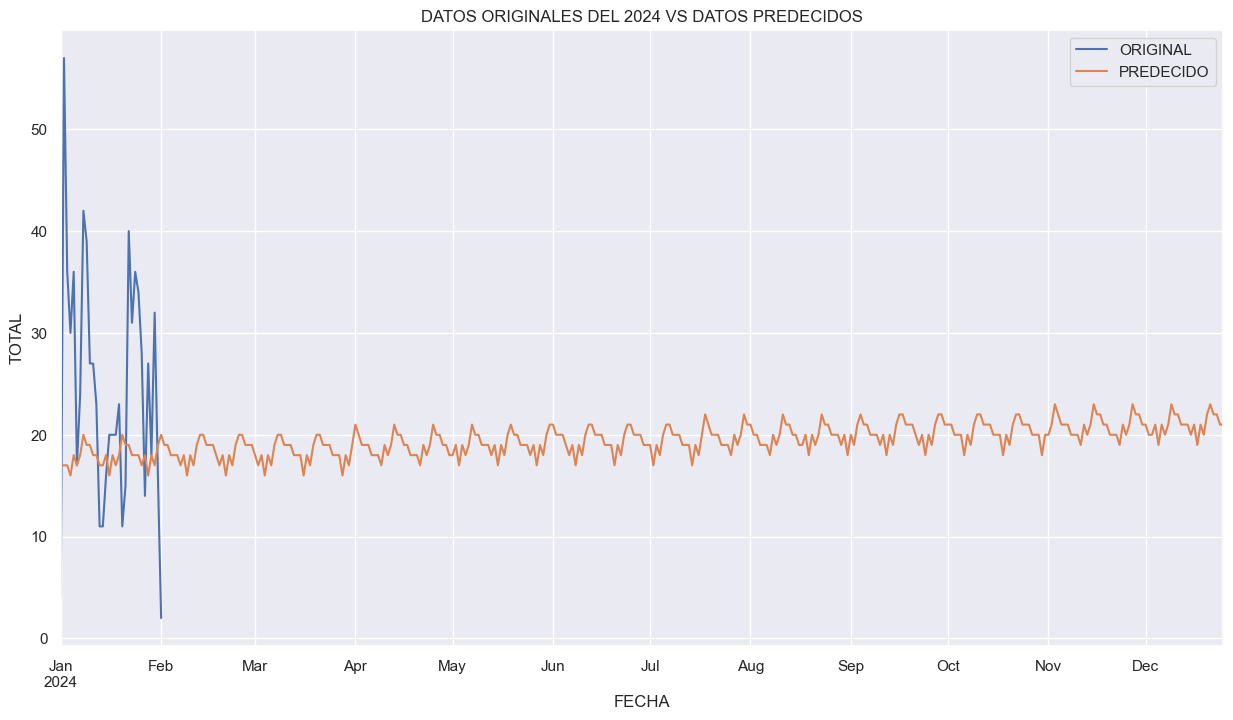

In [91]:
fig, ax = plt.subplots(figsize=(15,8))
df_gam_2024['total_fugas'].plot(legend=True, label='ORIGINAL', ax=ax)
test_predictions.plot(legend=True, label='PREDECIDO', ax=ax)
plt.title('datos originales del 2024 vs datos predecidos'.upper())
ax.set_xlabel("FECHA")
ax.set_ylabel("TOTAL")
plt.show()

In [92]:
df_gam_2024.loc['2024-01-01':'2024-01-31'].shape, test_predictions.loc['2024-01-01':'2024-01-31'].shape

((31, 2), (31,))

In [93]:
rmse = root_mean_squared_error(df_gam_2024.loc['2024-01-01':'2024-01-31']['total_fugas'], test_predictions.loc['2024-01-01':'2024-01-31']).round(2)

In [94]:
mape = mean_absolute_percentage_error(df_gam_2024.loc['2024-01-01':'2024-01-31']['total_fugas'], test_predictions.loc['2024-01-01':'2024-01-31']).round(2) * 100

In [95]:
pl.DataFrame({'RMSE': rmse, 'MAPE': mape})

shape: (1, 2)
┌──────┬──────┐
│ RMSE ┆ MAPE │
│ ---  ┆ ---  │
│ f64  ┆ f64  │
╞══════╪══════╡
│ 13.5 ┆ 46.0 │
└──────┴──────┘

# Predicción ARIMA & SARIMAX

In [111]:
# Elegimos el que va por mes
df_gam_monthly_agg.head()

total_fugas  avg_fugas  std_fugas           alcaldia  \
fecha_reporte                                                         
2021-01-31             545  17.580645  10.115250  GUSTAVO A. MADERO   
2021-02-28             425  15.178571  11.068988  GUSTAVO A. MADERO   
2021-03-31             367  11.838710  10.040242  GUSTAVO A. MADERO   
2021-04-30             427  14.233333   7.523221  GUSTAVO A. MADERO   
2021-05-31             394  12.709677   9.515579  GUSTAVO A. MADERO   

               total_fugas_1  total_fugas_ADD  total_fugas_MUL     TF3_ADD  \
fecha_reporte                                                                
2021-01-31        545.000000       403.703490       420.023803  454.869774   
2021-02-28        545.000000       429.292615       442.134721  274.985558   
2021-03-31        540.000000       441.788244       450.183247  477.164063   
2021-04-30        532.791667       447.417701       451.074203  370.762434   
2021-05-31        528.383681       457.777591       457.788456  573.257054   

                  TF3_MUL  
fecha_reporte              
2021-01-31     456.680405  
2021-02-28     326.444135  
2021-03-31     529.281807  
2021-04-30     468.254940  
2021-05-31     632.821468

In [112]:
# Split into train and test set
size = int(len(df_gam_monthly_agg)*0.5)
# Split
train_des = df_gam_monthly_agg[size:]
test_des = df_gam_monthly_agg[:size]

In [113]:
 # Encontrar mejores parámetros automáticamente para ARIMA
auto_model = auto_arima(train_des['total_fugas'], seasonal=False, stepwise=True,
                           suppress_warnings=True, error_action="ignore")

In [115]:
# Crear y entrenar modelo ARIMA
order = auto_model.order
arima_model = ARIMA(train_des['total_fugas'], order=order)
arima_fit = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            total_fugas   No. Observations:                   18
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -120.446
Date:                Thu, 05 Dec 2024   AIC                            252.892
Time:                        15:20:29   BIC                            258.234
Sample:                    07-31-2022   HQIC                           253.629
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        672.7967     93.747      7.177      0.000     489.056     856.537
ar.L1         -0.3049      0.399     -0.765      0.444      -1.086       0.476
ar.L2          0.1006      0.411      0.245      0.807      -0.706       0.907
ma.L1          0.5391      4.470      0.121      0.904      -8.221       9.299
ma.L2          0.9919     16.480      0.060      0.952     -31.309      33.292
sigma2      2.897e+04   4.68e+05      0.062      0.951   -8.88e+05    9.46e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.94   Prob(JB):                         0.97
Heteroskedasticity (H):               1.15   Skew:                             0.14
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [116]:
# Crear y entrenar modelo SARIMAX (con componente estacional)
sarimax_model = SARIMAX(train_des['total_fugas'], 
                        order=order,
                        seasonal_order=(1, 1, 1, 12))  # Ajustar según estacionalidad
sarimax_fit = sarimax_model.fit(disp=False)
sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          total_fugas   No. Observations:                   18
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 12)   Log Likelihood                 -38.317
Date:                              Thu, 05 Dec 2024   AIC                             90.633
Time:                                      15:20:34   BIC                             89.175
Sample:                                  07-31-2022   HQIC                            84.798
                                       - 12-31-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9024      5.986      0.151      0.880     -10.830      12.635
ar.L2         -0.0102      8.451     -0.001      0.999     -16.573      16.553
ma.L1         -0.5519    678.975     -0.001      0.999   -1331.318    1330.215
ma.L2          0.9982   2442.609      0.000      1.000   -4786.427    4788.423
ar.S.L12       0.9993   4.46e+04   2.24e-05      1.000   -8.75e+04    8.75e+04
ma.S.L12      -0.9995   4.71e+04  -2.12e-05      1.000   -9.23e+04    9.23e+04
sigma2       1.15e+04    121.105     94.951      0.000    1.13e+04    1.17e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):                 0.70
Prob(Q):                              0.40   Prob(JB):                         0.70
Heteroskedasticity (H):               1.67   Skew:                            -0.20
Prob(H) (two-sided):                  0.75   Kurtosis:                         1.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.55e+21. Standard errors may be unstable.
"""

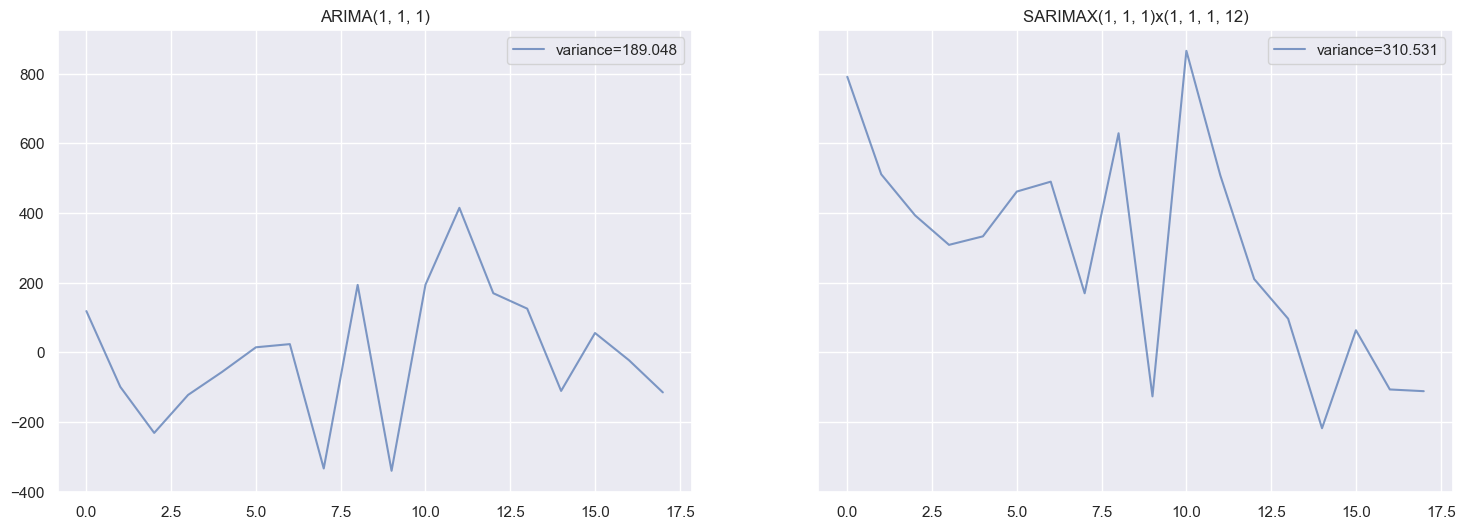

In [117]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(18, 6))
ax[0].plot(arima_fit.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(arima_fit.resid.values)));
# ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(1, 1, 1)");
ax[0].legend();
ax[1].plot(sarimax_fit.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(sarimax_fit.resid.values)));
# ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("SARIMAX(1, 1, 1)x(1, 1, 1, 12)");
ax[1].legend();

plt.show()

In [118]:
# Realizar predicciones
arima_pred = arima_fit.forecast(len(test_des['total_fugas']))
sarimax_pred = sarimax_fit.forecast(len(test_des['total_fugas']))
metricas = []
# Calcular métricas
metricas.append({
    "Model": "ARIMA",
    "MSE": mean_squared_error(test_des['total_fugas'], arima_pred).round(2),
    "MAE": mean_absolute_error(test_des['total_fugas'], arima_pred).round(2),
    "RMSE": root_mean_squared_error(test_des['total_fugas'], arima_pred).round(2),
    "MAPE": mean_absolute_percentage_error(test_des['total_fugas'], arima_pred).round(2)
})

metricas.append({
    "Model": "SARIMAX",
    "MSE": mean_squared_error(test_des['total_fugas'], sarimax_pred).round(2),
    "MAE": mean_absolute_error(test_des['total_fugas'], sarimax_pred).round(2),
    "RMSE": root_mean_squared_error(test_des['total_fugas'], sarimax_pred).round(2),
    "MAPE": mean_absolute_percentage_error(test_des['total_fugas'], sarimax_pred).round(2)
})

pd.DataFrame(metricas)

Model        MSE     MAE    RMSE  MAPE
0    ARIMA   55666.19  205.20  235.94  0.54
1  SARIMAX  199866.55  342.14  447.06  0.86

In [120]:
 # Predecir 12 meses hacia adelante
arima_forecast = arima_fit.forecast(steps=60)
sarimax_forecast = sarimax_fit.forecast(steps=60)

# Crear fechas para 2024
future_dates = pd.date_range(start='2024-01-01', periods=60, freq='d')

# Crear DataFrame con predicciones
predictions = pd.DataFrame({
    'Fecha': future_dates,
    'ARIMA': arima_forecast.round(0),
    'SARIMAX': sarimax_forecast.round(0)
}).set_index('Fecha')

In [121]:
predictions.head()

ARIMA  SARIMAX
Fecha                     
2024-01-01  587.0    665.0
2024-01-02  592.0    281.0
2024-01-03  689.0    743.0
2024-01-04  660.0     18.0
2024-01-05  678.0    993.0

In [123]:
# Asignamos la frecuencia por mes
predictions_arima_monthly_agg = predictions.ARIMA.resample('M').agg(['sum', 'mean', 'std'])
predictions_arima_monthly_agg.columns = ['total_fugas', 'avg_fugas', 'std_fugas']
predictions_arima_monthly_agg.loc[:, "alcaldia"] = "GUSTAVO A. MADERO"

In [124]:
# Asignamos la frecuencia por mes
predictions_sarima_monthly_agg = predictions.SARIMAX.resample('M').agg(['sum', 'mean', 'std'])
predictions_sarima_monthly_agg.columns = ['total_fugas', 'avg_fugas', 'std_fugas']
predictions_sarima_monthly_agg.loc[:, "alcaldia"] = "GUSTAVO A. MADERO"

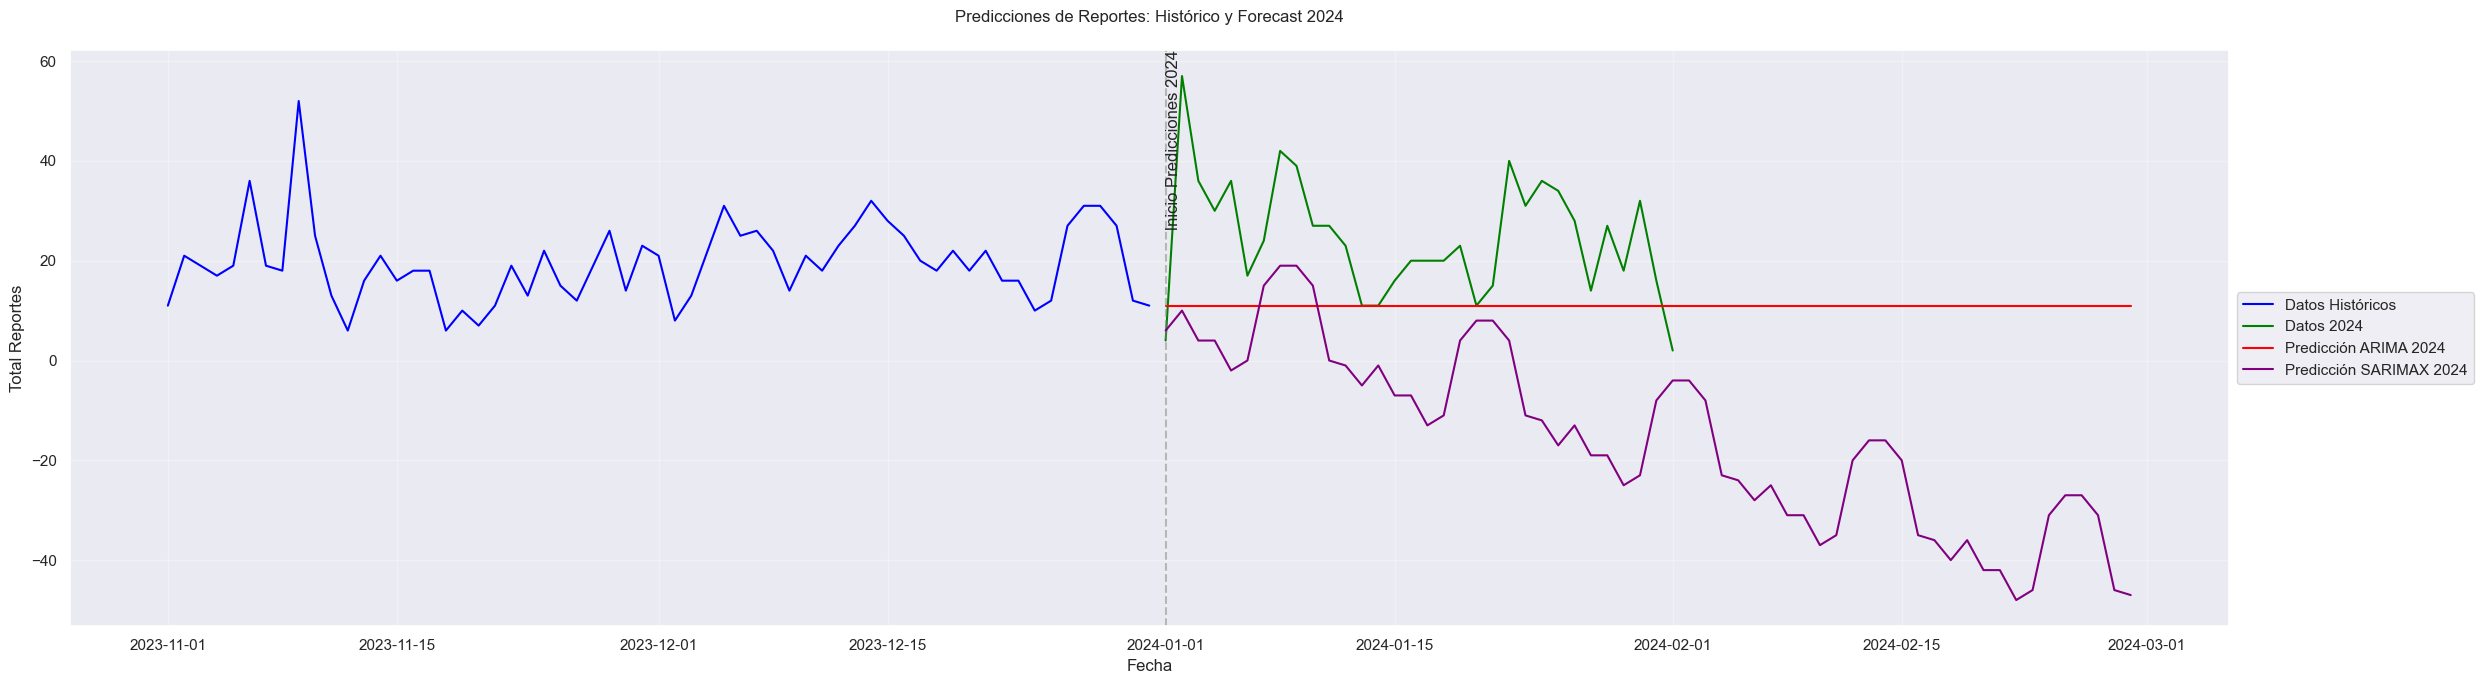

In [109]:
plt.figure(figsize=(25, 7))
    
# Datos históricos
plt.plot(df_gam.index[(df_gam.index.year == 2023) & (df_gam.index.month > 10)], df_gam.loc[(df_gam.index.year == 2023) & (df_gam.index.month > 10), 'total_fugas'], label='Datos Históricos', color='blue')

# Datos del mes de enero 2024
plt.plot(df_gam_2024.index, df_gam_2024['total_fugas'], label='Datos 2024', color='green')

# Predicciones 2024
plt.plot(predictions.index, predictions['ARIMA'].round(0), 
            label='Predicción ARIMA 2024',color='red')
plt.plot(predictions.index, predictions['SARIMAX'].round(0), 
            label='Predicción SARIMAX 2024', color='purple')

# Añadir una línea vertical para separar datos históricos de predicciones
plt.axvline(x=df_gam_2024.index[0], color='gray', linestyle='--', alpha=0.5)
plt.text(df_gam_2024.index[0], plt.ylim()[1], ' Inicio Predicciones 2024', 
            rotation=90, verticalalignment='top')

# Personalizar el gráfico
plt.title('Predicciones de Reportes: Histórico y Forecast 2024', pad=20)
plt.xlabel('Fecha')
plt.ylabel('Total Reportes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, alpha=0.3)

# Ajustar los márgenes para que quepa la leyenda
plt.tight_layout()
plt.show()

In [151]:
# Guardamos el modelo SARIMAX
sarimax_fit.save('../ml_models/sarimax_gam.pkl')

In [144]:
df_gam_monthly_agg.to_parquet('../DATASETS/df_gam_monthly_agg.parquet.gzip', compression='gzip')

# Modelo General CDMX

In [148]:
df_cdmx = df_por_fecha[df_por_fecha.fecha_reporte.dt.year != 2024]

df_cdmx.set_index("fecha_reporte", inplace=True)
df_cdmx.sort_index(inplace=True)

In [149]:
df_cdmx.head()

alcaldia_catalogo  total_fugas
fecha_reporte                                
2021-01-01               TLALPAN            2
2021-01-01            CUAUHTEMOC            2
2021-01-01            XOCHIMILCO            1
2021-01-01     GUSTAVO A. MADERO            1
2021-01-01        ALVARO OBREGON            3

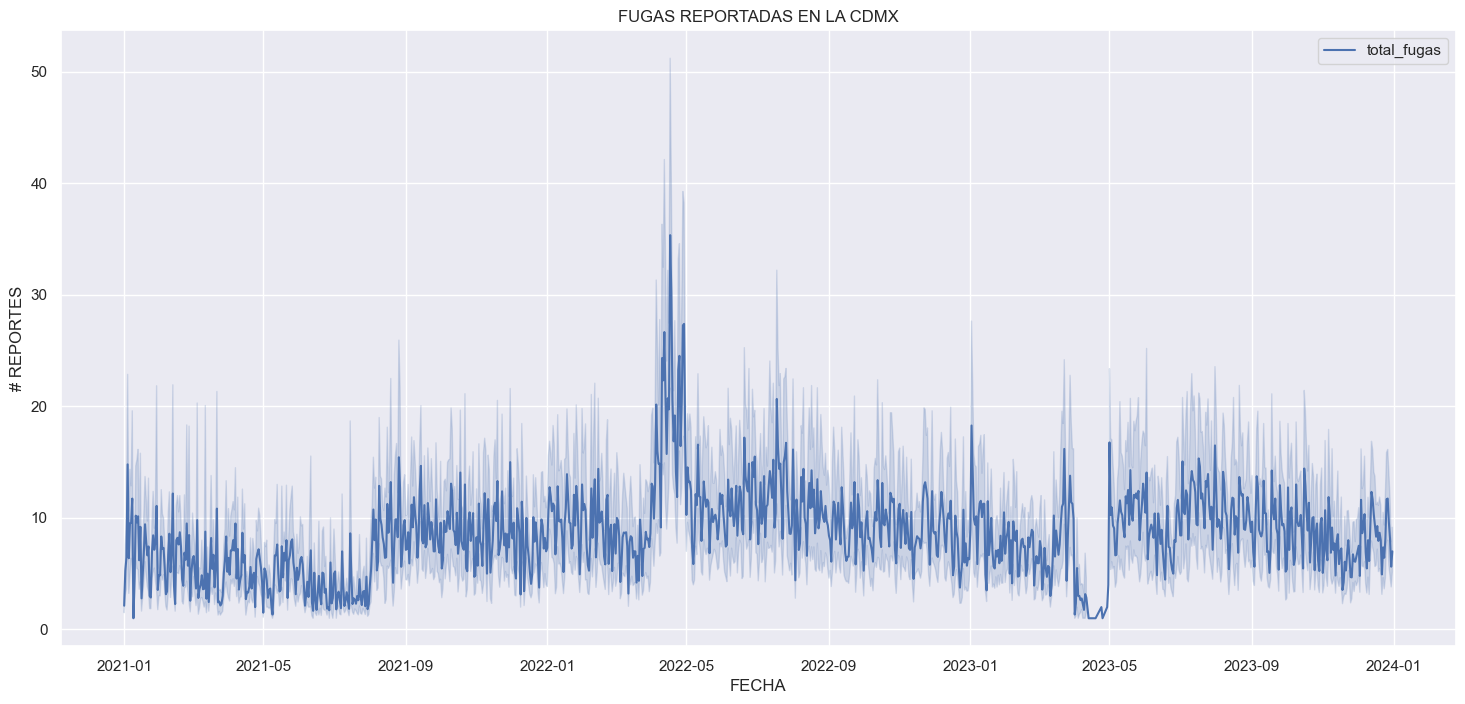

In [152]:
fig, ax = plt.subplots(figsize=(18, 8))
g = sns.lineplot(df_cdmx, ax=ax)
g.set(
    xlabel="fecha".upper(),
    ylabel="# Reportes".upper(),
    title='Fugas reportadas en la CDMX'.upper()
)
plt.show()

In [166]:
# frecuencia x dia
df_cdmx = df_cdmx.total_fugas.resample('d').agg(['sum'])
df_cdmx.columns = ['total_fugas']

In [167]:
result = sts.adfuller(df_cdmx.total_fugas)
print("<----- {} ------>".format("CDMX"))
print('Estadístico ADF:', result[0])
print('p-value:', result[1])
print('Valores críticos:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

<----- CDMX ------>
Estadístico ADF: -4.13060766585115
p-value: 0.000861648621548234
Valores críticos:
	1%: -3.4364647646486093
	5%: -2.864239892228526
	10%: -2.5682075189699822


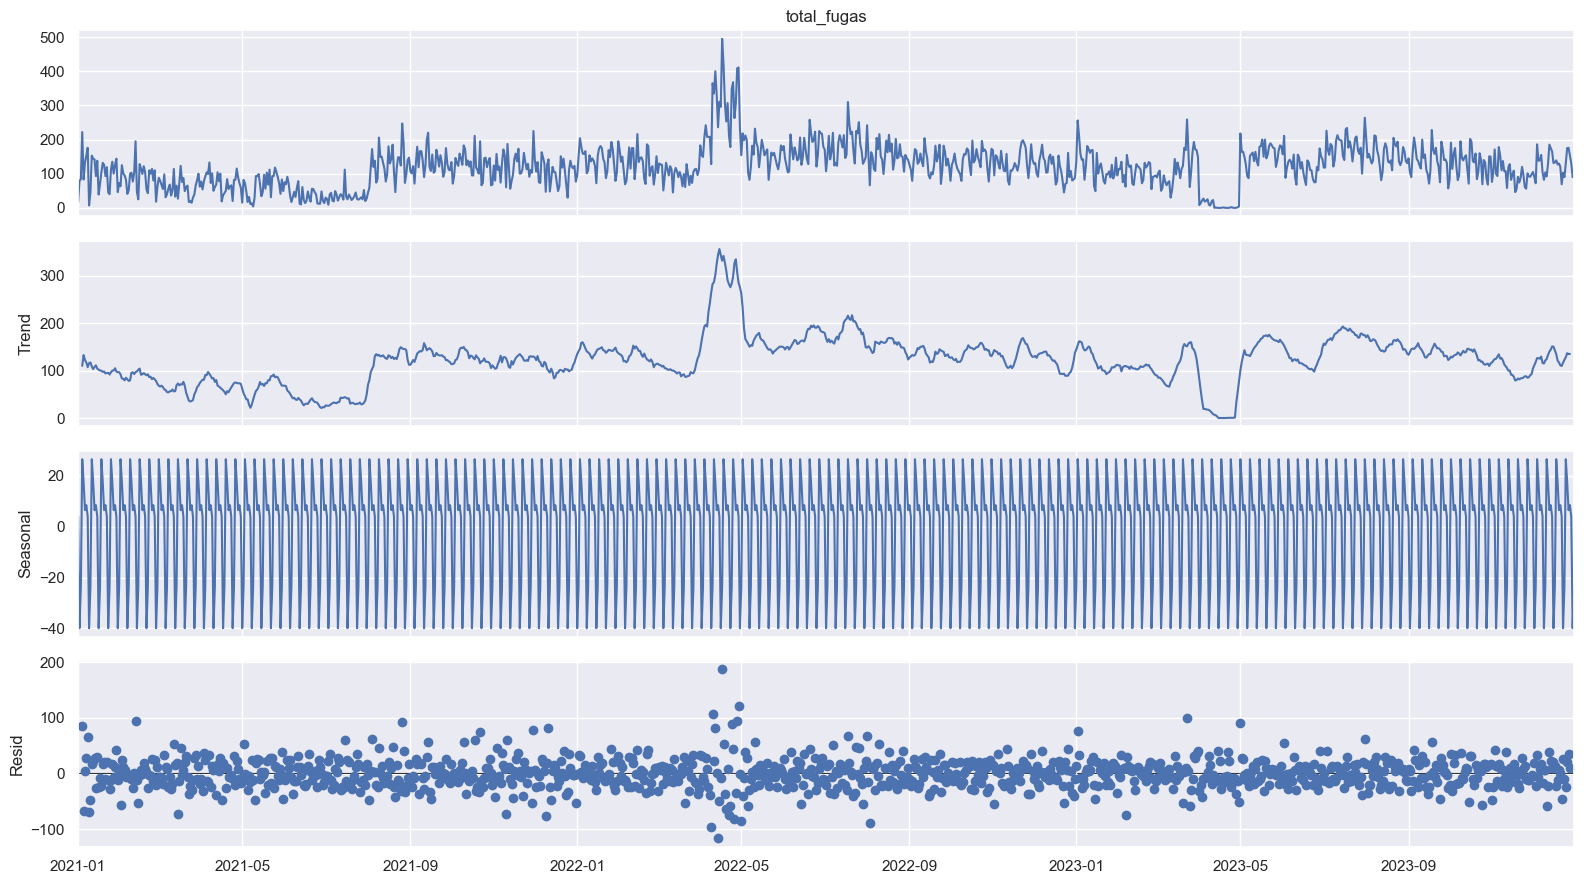

In [168]:
# Descomponemos la serie para ver sus componentes
decompose_result_add = seasonal_decompose(df_cdmx.total_fugas, model='additive')
fig = decompose_result_add.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

In [169]:
# Asignamos la frecuencia por mes
df_cdmx_monthly_agg = df_cdmx.total_fugas.resample('M').agg(['sum', 'mean', 'std'])
df_cdmx_monthly_agg.columns = ['total_fugas', 'avg_fugas', 'std_fugas']

In [170]:
df_cdmx_monthly_agg.head()

total_fugas   avg_fugas  std_fugas
fecha_reporte                                    
2021-01-31            3172  102.322581  49.284472
2021-02-28            2466   88.071429  37.596226
2021-03-31            1872   60.387097  28.024605
2021-04-30            2208   73.600000  26.658246
2021-05-31            1969   63.516129  34.145640

In [171]:
# Corroborar si coincide el dato
df_cdmx[(df_cdmx.index.month == 1) & (df_cdmx.index.year == 2021)].total_fugas.sum()

3172

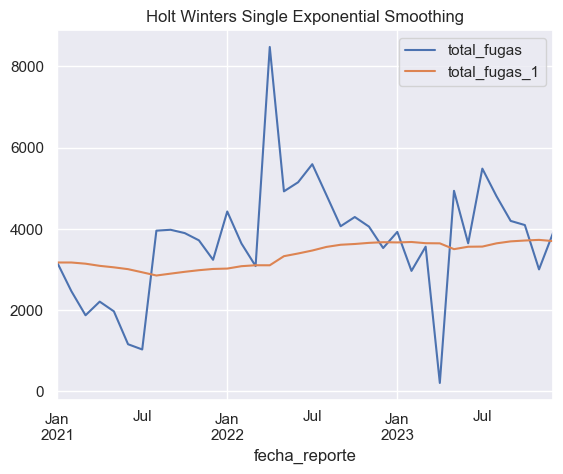

In [ ]:
m = 12
alpha = 1/(2*m)
# Suavizado exponencial
df_cdmx_monthly_agg.loc[:, 'total_fugas_1'] = SimpleExpSmoothing(df_cdmx_monthly_agg.total_fugas).fit(smoothing_level=alpha, optimized=False, use_brute=True).fittedvalues
df_cdmx_monthly_agg[['total_fugas','total_fugas_1']].plot(title='Holt Winters Single Exponential Smoothing')
plt.show()

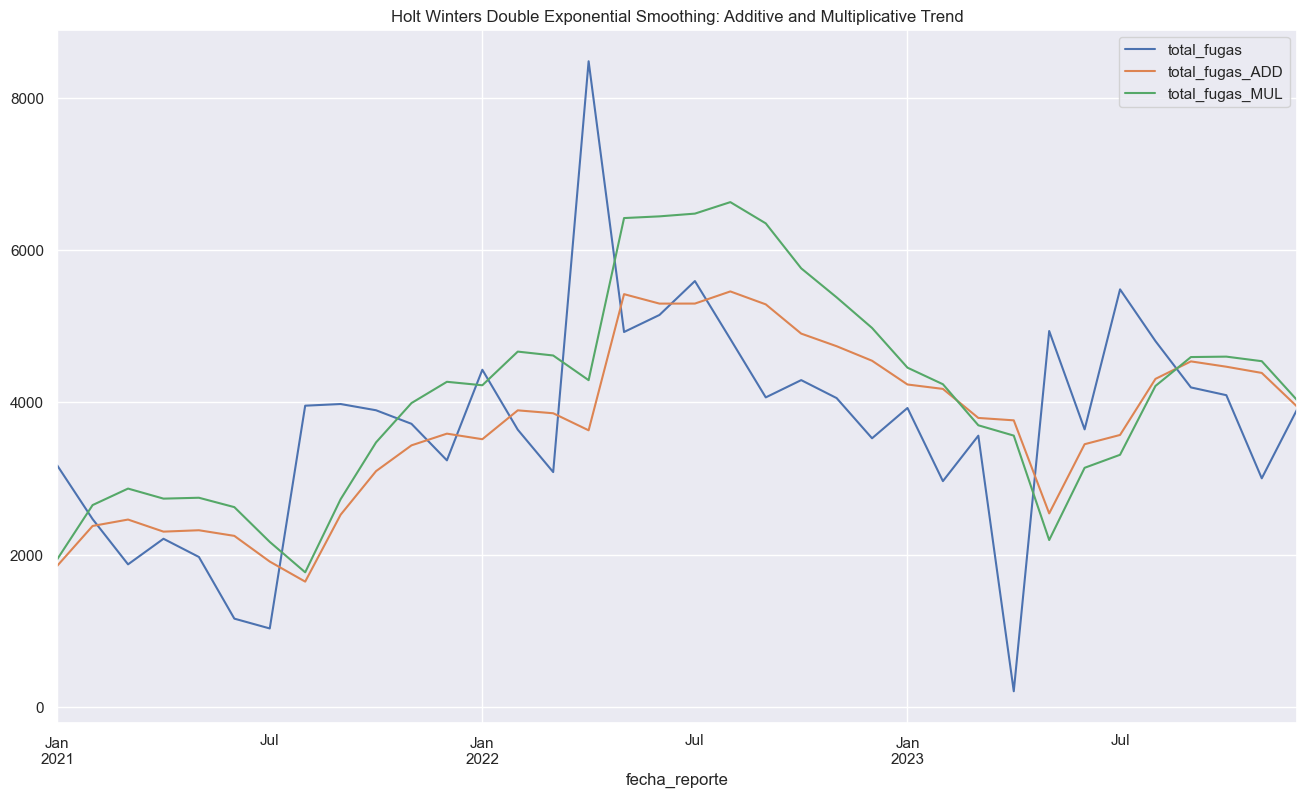

In [173]:
df_cdmx_monthly_agg.loc[:, 'total_fugas_ADD'] = ExponentialSmoothing(df_cdmx_monthly_agg.total_fugas, trend='add').fit().fittedvalues
df_cdmx_monthly_agg.loc[:, 'total_fugas_MUL'] = ExponentialSmoothing(df_cdmx_monthly_agg.total_fugas, trend='mul').fit().fittedvalues
fig = df_cdmx_monthly_agg[['total_fugas','total_fugas_ADD','total_fugas_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend', figsize=(16, 9))
plt.show()

## Pronostico con ExponentialSmoothing

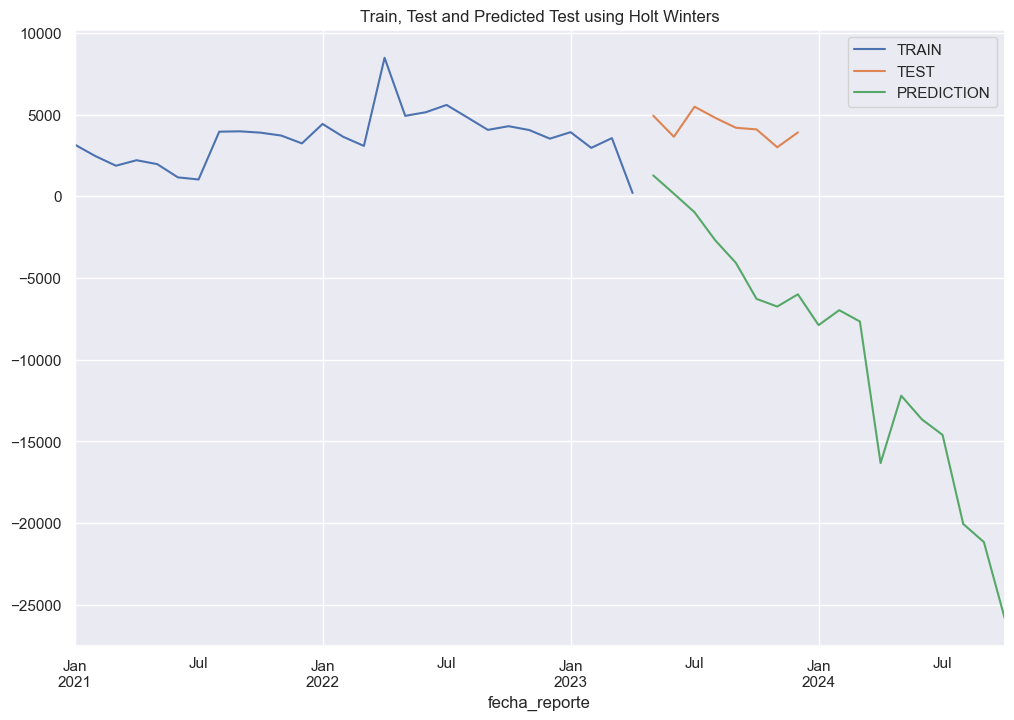

In [174]:
# Tamaño de los datos de entrenamiento
size = int(len(df_cdmx_monthly_agg)*0.8)

# Split into train and test set
train_des = df_cdmx_monthly_agg[:size]
test_des = df_cdmx_monthly_agg[size:]

fig, ax = plt.subplots(figsize=(12, 8))

fitted_model = ExponentialSmoothing(train_des['total_fugas'], trend='add', seasonal='mul', seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(18)
train_des['total_fugas'].plot(legend=True, label='TRAIN', ax=ax)
test_des['total_fugas'].plot(legend=True, label='TEST', ax=ax)
test_predictions.plot(legend=True, label='PREDICTION', ax=ax)
plt.title('Train, Test and Predicted Test using Holt Winters')

plt.show()

## Pronostico con ARIMA & SARIMAX

In [175]:
 # Encontrar mejores parámetros automáticamente para ARIMA
auto_model = auto_arima(train_des['total_fugas'], seasonal=False, stepwise=True,
                        suppress_warnings=True, error_action="ignore")

# Crear y entrenar modelo ARIMA
order = auto_model.order
arima_model = ARIMA(train_des['total_fugas'], order=order)
arima_fit = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            total_fugas   No. Observations:                   28
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -242.682
Date:                Sat, 30 Nov 2024   AIC                            491.365
Time:                        16:41:41   BIC                            495.361
Sample:                    01-31-2021   HQIC                           492.587
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3549.6784    621.176      5.714      0.000    2332.196    4767.161
ar.L1          0.4805      0.247      1.943      0.052      -0.004       0.965
sigma2      2.024e+06   3.45e+05      5.872      0.000    1.35e+06     2.7e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                40.91
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             1.37
Prob(H) (two-sided):                  0.82   Kurtosis:                         8.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [176]:
# Crear y entrenar modelo SARIMAX (con componente estacional)
sarimax_model = SARIMAX(train_des['total_fugas'], 
                        order=order,
                        seasonal_order=(1, 1, 1, 12))  # Ajustar según estacionalidad
sarimax_fit = sarimax_model.fit(disp=False)
sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          total_fugas   No. Observations:                   28
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -355.260
Date:                              Sat, 30 Nov 2024   AIC                            718.521
Time:                                      16:42:13   BIC                            721.611
Sample:                                  01-31-2021   HQIC                           718.679
                                       - 04-30-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5000   2.02e+11   2.48e-12      1.000   -3.96e+11    3.96e+11
ar.S.L12            0   2.55e+12          0      1.000   -5.01e+12    5.01e+12
ma.S.L12            0   2.56e+12          0      1.000   -5.01e+12    5.01e+12
sigma2      3.074e+18   2.39e+06   1.29e+12      0.000    3.07e+18    3.07e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                15.45
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                            -1.30
Prob(H) (two-sided):                  0.40   Kurtosis:                         7.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.38e+28. Standard errors may be unstable.
"""

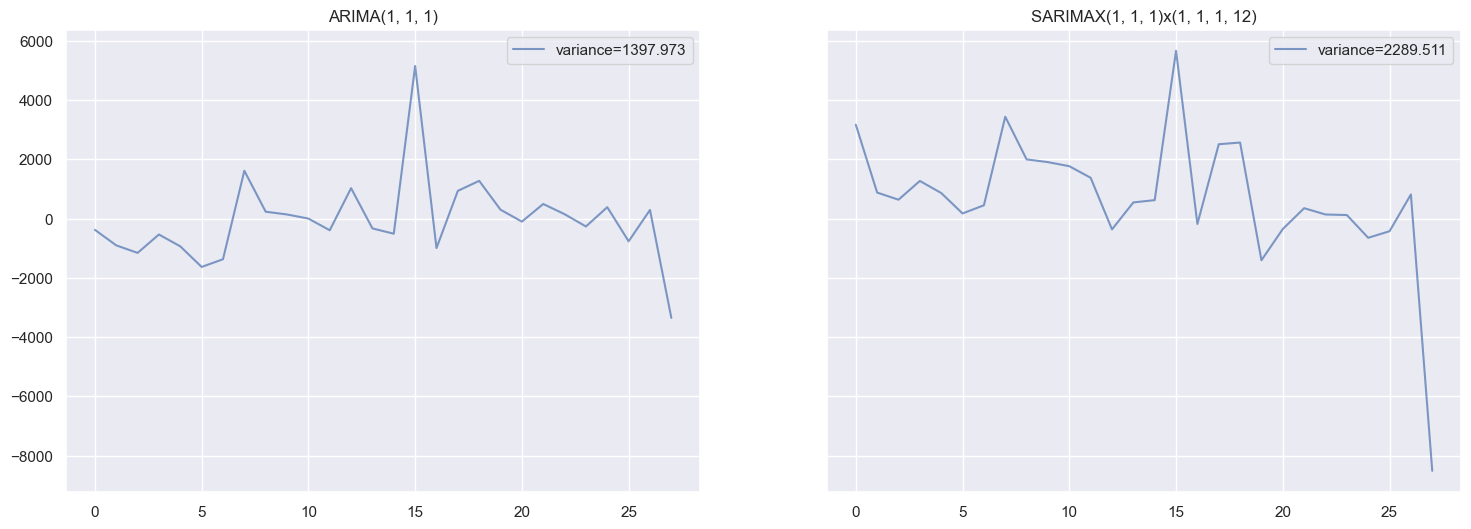

In [177]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(18, 6))
ax[0].plot(arima_fit.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(arima_fit.resid.values)));
# ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(1, 1, 1)");
ax[0].legend();
ax[1].plot(sarimax_fit.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(sarimax_fit.resid.values)));
# ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("SARIMAX(1, 1, 1)x(1, 1, 1, 12)");
ax[1].legend();

plt.show()

### Predicciones

In [178]:
# Realizar predicciones
arima_pred = arima_fit.forecast(len(test_des['total_fugas']))
sarimax_pred = sarimax_fit.forecast(len(test_des['total_fugas']))
metricas = []
# Calcular métricas
metricas.append({
    "Model": "ARIMA",
    "MSE": mean_squared_error(test_des['total_fugas'], arima_pred).round(2),
    "MAE": mean_absolute_error(test_des['total_fugas'], arima_pred).round(2),
    "RMSE": root_mean_squared_error(test_des['total_fugas'], arima_pred).round(2),
    "MAPE": mean_absolute_percentage_error(test_des['total_fugas'], arima_pred).round(2)
})

metricas.append({
    "Model": "SARIMAX",
    "MSE": mean_squared_error(test_des['total_fugas'], sarimax_pred).round(2),
    "MAE": mean_absolute_error(test_des['total_fugas'], sarimax_pred).round(2),
    "RMSE": root_mean_squared_error(test_des['total_fugas'], sarimax_pred).round(2),
    "MAPE": mean_absolute_percentage_error(test_des['total_fugas'], sarimax_pred).round(2)
})

df_metrics_cdmx = pd.DataFrame(metricas)

In [179]:
df_metrics_cdmx

Model         MSE      MAE     RMSE  MAPE
0    ARIMA  2297235.95  1226.71  1515.66  0.27
1  SARIMAX  2493564.64   998.97  1579.10  0.23

In [180]:
 # Predecir 12 meses hacia adelante
arima_forecast = arima_fit.forecast(steps=60)
sarimax_forecast = sarimax_fit.forecast(steps=60)

# Crear fechas para 2024
future_dates = pd.date_range(start='2024-01-01', periods=60, freq='d')

# Crear DataFrame con predicciones
predictions = pd.DataFrame({
    'Fecha': future_dates,
    'ARIMA': arima_forecast.round(0),
    'SARIMAX': sarimax_forecast.round(0)
}).set_index('Fecha')

In [182]:
predictions.head()

ARIMA  SARIMAX
Fecha                      
2024-01-01  1943.0    786.0
2024-01-02  2778.0   3079.0
2024-01-03  3179.0   4559.0
2024-01-04  3371.0   4315.0
2024-01-05  3464.0   3806.0

In [183]:
predictions = predictions.asfreq('d')

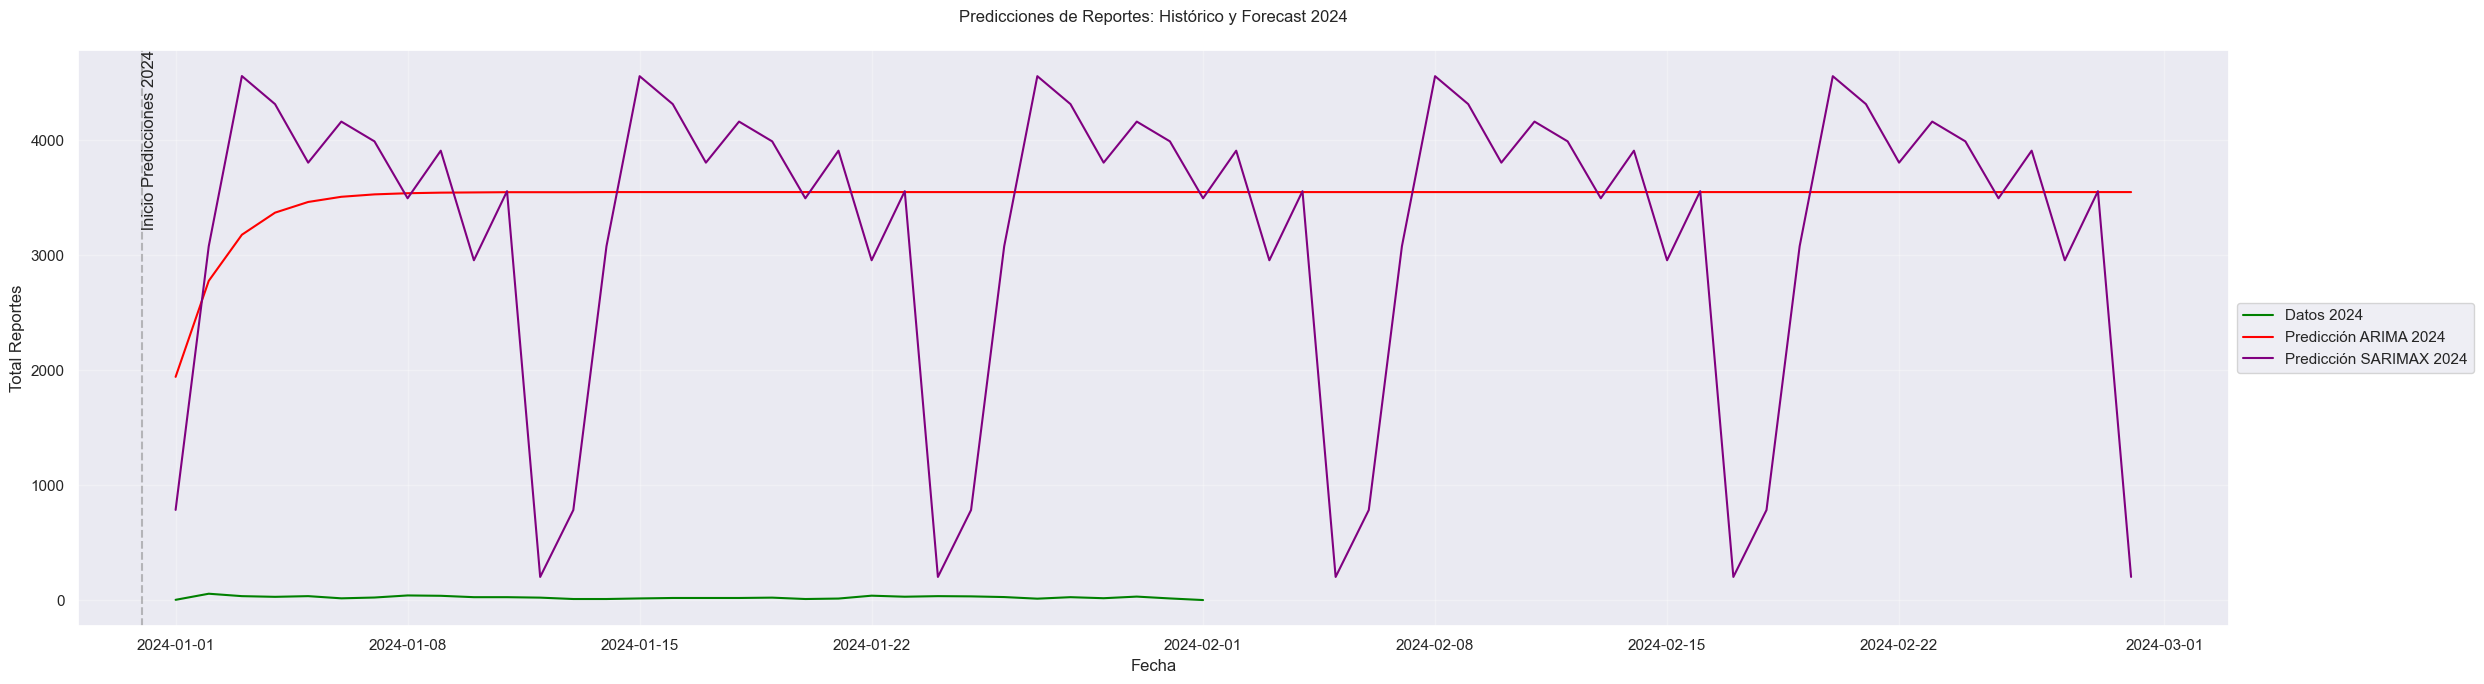

In [ ]:
plt.figure(figsize=(25, 7))
    
# Datos históricos
# plt.plot(df_gam.index[(df_gam.index.year == 2023) & (df_gam.index.month > 10)], df_gam.loc[(df_gam.index.year == 2023) & (df_gam.index.month > 10), 'total_fugas'], label='Datos Históricos', color='blue')

# Datos del mes de enero 2024
plt.plot(df_gam_2024.index, df_gam_2024['total_fugas'], label='Datos 2024', color='green')

# Predicciones 2024
plt.plot(predictions.index, predictions['ARIMA'].round(0), 
            label='Predicción ARIMA 2024',color='red')
plt.plot(predictions.index, predictions['SARIMAX'].round(0), 
            label='Predicción SARIMAX 2024', color='purple')

# Añadir una línea vertical para separar datos históricos de predicciones
plt.axvline(x=test_des.index[-1], color='gray', linestyle='--', alpha=0.5)
plt.text(test_des.index[-1], plt.ylim()[1], ' Inicio Predicciones 2024', 
            rotation=90, verticalalignment='top')

# Personalizar el gráfico
plt.title('Predicciones de Reportes: Histórico y Forecast 2024', pad=20)
plt.xlabel('Fecha')
plt.ylabel('Total Reportes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, alpha=0.3)

# Ajustar los márgenes para que quepa la leyenda
plt.tight_layout()
plt.show()

### Guardando el modelo

In [185]:
# Guardamos el modelo SARIMAX
sarimax_fit.save('../ml_models/sarimax_cdmx.pkl')

In [ ]:
predictions[['SARIMAX']]

In [189]:
# Guardando los datos
df_cdmx['TARGET'] = 'ORIGEN'

In [191]:
df_cdmx

total_fugas  TARGET
fecha_reporte                     
2021-01-01              17  ORIGEN
2021-01-02              79  ORIGEN
2021-01-03              84  ORIGEN
2021-01-04             222  ORIGEN
2021-01-05              83  ORIGEN
...                    ...     ...
2023-12-27             176  ORIGEN
2023-12-28             154  ORIGEN
2023-12-29             130  ORIGEN
2023-12-30              90  ORIGEN
2023-12-31              91  ORIGEN

[1095 rows x 2 columns]

In [194]:
df_temp = predictions[['SARIMAX']]
df_temp.columns = ['total_fugas']
df_temp['TARGET'] = 'PRONOSTICO'

In [196]:
df_combinado = pd.concat([df_cdmx, df_temp])

In [199]:
# Guardando los datos
df_combinado.to_parquet('../DATASETS/combinado_fugas.parquet.gzip', compression='gzip')

In [230]:
df = pl.read_parquet('../DATASETS/combinado_fugas.parquet.gzip')
# df = df.reset_index(names='fecha_reporte')
df.columns = ['total_fugas', 'target', 'fecha_reporte']
df

shape: (1_155, 3)
┌─────────────┬────────────┬─────────────────────┐
│ total_fugas ┆ target     ┆ fecha_reporte       │
│ ---         ┆ ---        ┆ ---                 │
│ f64         ┆ str        ┆ datetime[ns]        │
╞═════════════╪════════════╪═════════════════════╡
│ 17.0        ┆ ORIGEN     ┆ 2021-01-01 00:00:00 │
│ 79.0        ┆ ORIGEN     ┆ 2021-01-02 00:00:00 │
│ 84.0        ┆ ORIGEN     ┆ 2021-01-03 00:00:00 │
│ 222.0       ┆ ORIGEN     ┆ 2021-01-04 00:00:00 │
│ 83.0        ┆ ORIGEN     ┆ 2021-01-05 00:00:00 │
│ …           ┆ …          ┆ …                   │
│ 3496.0      ┆ PRONOSTICO ┆ 2024-02-25 00:00:00 │
│ 3910.0      ┆ PRONOSTICO ┆ 2024-02-26 00:00:00 │
│ 2957.0      ┆ PRONOSTICO ┆ 2024-02-27 00:00:00 │
│ 3558.0      ┆ PRONOSTICO ┆ 2024-02-28 00:00:00 │
│ 203.0       ┆ PRONOSTICO ┆ 2024-02-29 00:00:00 │
└─────────────┴────────────┴─────────────────────┘

# Enviando los datos a SQL

In [235]:
import os
from sqlalchemy import create_engine

user = os.getenv("POSTGRES_USER", "postgres")
password = os.getenv("POSTGRES_PASSWORD", "postgres")
host = os.getenv("POSTGRES_HOST", "localhost")
port = os.getenv("POSTGRES_PORT", "5432")
db = os.getenv("POSTGRES_DB", "sacmex")

conn = psycopg2.connect(
    host=os.getenv("POSTGRES_HOST", "localhost"),
    database=os.getenv("POSTGRES_DB", "sacmex"),
    user=os.getenv("POSTGRES_USER", "postgres"),
    password=os.getenv("POSTGRES_PASSWORD", "postgres"),
    port=os.getenv("POSTGRES_PORT", "5432")
)

engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{db}')

In [241]:
df_por_fecha.to_parquet('../DATASETS/datos_por_alcaldia_y_fecha.parquet.gzip', index=False, compression='gzip')

In [212]:
#
try:
    with conn.cursor() as cur:
        cur.execute("DROP TABLE IF EXISTS fugas_por_fecha")
        cur.execute("DROP TABLE IF EXISTS fugas_por_delegacion")

        cur.execute("""
            CREATE TABLE fugas_por_fecha (
                id BIGSERIAL PRIMARY KEY,
                fecha_reporte DATE NOT NULL,
                total_fugas INT NOT NULL,
                target VARCHAR(20) NOT NULL
            )
        """)

        cur.execute("""
            CREATE TABLE fugas_por_delegacion (
                id BIGSERIAL PRIMARY KEY,
                fecha_reporte DATE NOT NULL,
                alcaldia VARCHAR(60) NOT NULL,
                total_fugas INT NOT NULL
            )
        """)
        conn.commit()
finally:
    conn.close()

In [237]:
!pip install SQLAlchemy

In [238]:
uri = f'postgresql://{user}:{password}@{host}:{port}/{db}'

df.write_database(table_name="fugas_por_fecha", connection=uri)

ModuleUpgradeRequiredError: pandas >= 2.2 requires sqlalchemy 2.0 or higher (found 1.4.52)